<font size="7">**Progetto per il corso Machine Learning**</font>

<font size="6">*Music Genre Classification Challenge - CrowdAI*</font>


<font size="5">Monnati Francesco</font>

<font size="7">**Introduzione**</font>

La competizione rientra nella disciplina *Music Information Retrieval* e consiste nel classificare il genere musicale delle canzoni presenti nel dataset FMA (Free Music Archive). Quest'ultimo è strutturato in diverse versioni che differiscono per dimensione (small, medium, large e full) e per task: le prime due appartengono ad un task di *single-label classification*, dove le classi sono disgiunte e pertanto ogni classe appartiene ad una singola regione. Mentre i dataset large e full sono relativi ad un task di *multi-label classification* in cui una canzone può appartenere a diversi generi strutturati in una forma gerarchica. <br>
Il seguente notebook analizzerà il dataset medium che consiste di 25000 tracce appartenenti a 16 generi; i dati sono accessibili in forma .csv e in forma *raw*, ovvero tracce audio di lunghezza pari a 30 secondi per una dimensione complessiva di 22 Gb. L'analisi verterà su una comparazione di 3 modelli base del Machine Learning (KNN, SVC, MLP) in 3 diverse forme del dataset:
- dimensionalità ridotta attraverso PCA
- dimensionalità ridotta attraverso VarianceThreshold e Mutual Information
- dimensionalità ridotta attraverso PCA e *oversampling* attraverso SMOTE.

Inoltre verrà addestrata una CNN su spettrogrammi estratti dai file audio.
Il notebook è strutturato in diverse sezioni:
- EDA 
- Preprocessing
- Model Selection e successiva comparazione tra modelli migliori
- Addestramento CNN

Non disponendo di particolare potenza computazionale il codice è stato implementato su Google Colab, è' stato prima scaricato in locale il file zip relativo ai dati in forma .csv e poi caricato su Google Drive. Di seguito si collega il notebook a Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset/
!unzip '/content/drive/MyDrive/fma_metadata2.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/fma_metadata2.zip
   creating: /content/dataset/fma_metadata2/fma_metadata/
  inflating: /content/dataset/fma_metadata2/fma_metadata/checksums  
  inflating: /content/dataset/fma_metadata2/fma_metadata/echonest.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/features.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/genres.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/not_found.pickle  
  inflating: /content/dataset/fma_metadata2/fma_metadata/raw_albums.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/raw_artists.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/raw_echonest.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/raw_genres.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/raw_tracks.csv  
  inflating: /content/dataset/fma_metadata2/fma_metadata/README.txt  
  inflating: /content/dataset/fma_metadata2/fma_metadata/tracks.csv  


In [ ]:
import os
import ast
import numbers
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.svm
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest,VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, log_loss, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as smotepipeline
from xgboost import XGBClassifier
import warnings
import keras
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")


Nella cella superiore si importano una serie di librerie adottate nel notebook, la soppressione dei warning è dovuta alla libreria sklearn che genera degli avvertimenti legati alla particolare struttura a Multindex dei dataframe, struttura che si è deciso di mantenere e alla libreria imblearn per l'oversampling adottato di cui discuterò più avanti.
Nelle cella seguente invece vengono implementate alcune funzioni utili tra cui un paio per graficare degli andamenti a partire dai risultati ottenuti da una *GridSearchCV* o da una pandas dataframe, una funzione di oversampling custom che verrà utilizzata con SMOTE.

In [ ]:
plt.rcParams['figure.figsize'] = (16, 16)

def plot_validation_curve(grid, param_to_vary, second_parameter = None, value_second_parameter = None, title='Validation Curve', ylim=None,
                                      xlim=None, log=None):

    if second_parameter == None:
      df_cv_results = pd.DataFrame(grid.cv_results_)


      train_scores_mean = df_cv_results['mean_train_score']
      valid_scores_mean = df_cv_results['mean_test_score']
      train_scores_std = df_cv_results['std_train_score']
      valid_scores_std = df_cv_results['std_test_score']
      param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
      param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
      param_ranges_lengths = [len(pr) for pr in param_ranges]

      train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
      valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
      train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
      valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

      param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

      slices = []
      for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

      train_scores_mean = train_scores_mean[tuple(slices)]
      valid_scores_mean = valid_scores_mean[tuple(slices)]
      train_scores_std = train_scores_std[tuple(slices)]
      valid_scores_std = valid_scores_std[tuple(slices)]

      plt.clf()

      plt.title(title)
      plt.xlabel(param_to_vary)
      plt.ylabel('Mean F1 Score')
      if (ylim is None):
        plt.ylim(0.0, 1.1)
      else:
        plt.ylim(*ylim)

      if (not (xlim is None)):
        plt.xlim(*xlim)

      lw = 2

      plot_fn = plt.plot
      if log:
        plot_fn = plt.semilogx

      param_range = param_ranges[param_to_vary_idx]
      if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
      plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
      plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
      plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
      plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)
    else:
      df_cv_results = pd.DataFrame(grid.cv_results_)
      column_name_parameter = "param_" + second_parameter
      train_scores_mean = df_cv_results.loc[df_cv_results[column_name_parameter] == value_second_parameter, 'mean_train_score']
      valid_scores_mean = df_cv_results.loc[df_cv_results[column_name_parameter] == value_second_parameter, 'mean_test_score']
      train_scores_std = df_cv_results.loc[df_cv_results[column_name_parameter] == value_second_parameter, 'std_train_score']
      valid_scores_std = df_cv_results.loc[df_cv_results[column_name_parameter] == value_second_parameter, 'std_test_score']
      param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
      param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
      param_ranges_lengths = [len(pr) for pr in param_ranges]
      param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

      slices = []
      for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)
      plt.clf()

      plt.title(title)
      plt.xlabel(param_to_vary)
      plt.ylabel('Mean F1 Score')
      if (ylim is None):
        plt.ylim(0.0, 1.1)
      else:
        plt.ylim(*ylim)

      if (not (xlim is None)):
        plt.xlim(*xlim)

      lw = 2

      plot_fn = plt.plot
      if log:
        plot_fn = plt.semilogx

      param_range = param_ranges[param_to_vary_idx]
      if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
      plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
      plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
      plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
      plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    

    plt.legend(loc='upper left')

    plt.show()


      
def plot_learning_curve(train_sizes,grid,param_to_vary,param_value,second_parameter = None, second_parameter_value = None, title = 'Learning Curve'):
  if second_parameter == None:
    df_cv_results = pd.DataFrame(grid.cv_results_)
    column_name_parameter = "param_" + param_to_vary
    train_scores_mean = df_cv_results.loc[df_cv_results[column_name_parameter] == param_value, 'mean_train_score']
    valid_scores_mean = df_cv_results.loc[df_cv_results[column_name_parameter] == param_value, 'mean_test_score']
    train_scores_std = df_cv_results.loc[df_cv_results[column_name_parameter] == param_value, 'std_train_score']
    valid_scores_std = df_cv_results.loc[df_cv_results[column_name_parameter] == param_value, 'std_test_score'] 
    plt.plot(train_sizes, train_scores_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                     train_scores_mean - train_scores_std, color='blue', alpha=0.3)
    plt.plot(train_sizes, valid_scores_mean, label='test score', color='red', marker='o')
    plt.fill_between(train_sizes, valid_scores_mean + valid_scores_std, valid_scores_mean - valid_scores_std, color='red', alpha=0.3)
    plt.title(title)
    plt.xlabel('Number of training points')
    ax = plt.gca()
    ax.set_xticks(np.arange(30000, 45000,2500))
    plt.ylabel('Mean F1 Score')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()
  else:

    df_cv_results = pd.DataFrame(grid.cv_results_)
    column_name_parameter = "param_" + param_to_vary
    column_name_second_parameter = "param_" + second_parameter
    train_scores_mean = df_cv_results.loc[(df_cv_results[column_name_parameter] == param_value) & (df_cv_results[column_name_second_parameter] == second_parameter_value), 'mean_train_score']
    valid_scores_mean = df_cv_results.loc[(df_cv_results[column_name_parameter] == param_value) & (df_cv_results[column_name_second_parameter] == second_parameter_value), 'mean_test_score']
    train_scores_std = df_cv_results.loc[(df_cv_results[column_name_parameter] == param_value) & (df_cv_results[column_name_second_parameter] == second_parameter_value), 'std_train_score']
    valid_scores_std = df_cv_results.loc[(df_cv_results[column_name_parameter] == param_value) & (df_cv_results[column_name_second_parameter] == second_parameter_value), 'std_test_score'] 
    plt.plot(train_sizes, train_scores_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                     train_scores_mean - train_scores_std, color='blue', alpha=0.3)
    plt.plot(train_sizes, valid_scores_mean, label='test score', color='red', marker='o')
    plt.fill_between(train_sizes, valid_scores_mean + valid_scores_std, valid_scores_mean - valid_scores_std, color='red', alpha=0.3)
    plt.title(title)
    plt.xlabel('Number of training points')
    ax = plt.gca()
    ax.set_xticks(np.arange(30000, 45000,2500))
    plt.ylabel('Mean F1 Score')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()

def plot_validation_curve_from_df(grid,parameter_fixed,parameter_value,x_parameter):
  
  column_name_parameter = "param_" + parameter_fixed
  column_name_parameter_x_axis = "param_" + x_parameter
  x_axis_parameter = sorted(grid.loc[grid[column_name_parameter] == parameter_value, column_name_parameter_x_axis])
  train_scores_mean = []
  valid_scores_mean = []
  train_scores_std = []
  valid_scores_std = []
  for x in x_axis_parameter:
    train_scores_mean.append(grid.loc[(grid[column_name_parameter] == parameter_value) & (grid[column_name_parameter_x_axis] == x), 'mean_train_score'].values[0])
    valid_scores_mean.append(grid.loc[(grid[column_name_parameter] == parameter_value) & (grid[column_name_parameter_x_axis] == x), 'mean_test_score'].values[0])
    train_scores_std.append(grid.loc[(grid[column_name_parameter] == parameter_value) & (grid[column_name_parameter_x_axis] == x), 'std_train_score'].values[0])
    valid_scores_std.append(grid.loc[(grid[column_name_parameter] == parameter_value) & (grid[column_name_parameter_x_axis] == x), 'std_train_score'].values[0])

  plt.plot(x_axis_parameter, train_scores_mean, label='train score', color='blue', marker='o')
  plt.fill_between(x_axis_parameter, np.array(train_scores_mean) + np.array(train_scores_std),
                     np.array(train_scores_mean) - np.array(train_scores_std), color='blue', alpha=0.3)
  plt.plot(x_axis_parameter, valid_scores_mean, label='test score', color='red', marker='o')
  plt.fill_between(x_axis_parameter, np.array(valid_scores_mean) + np.array(valid_scores_std), np.array(valid_scores_mean) - np.array(valid_scores_std), color='red', alpha=0.3)
  plt.title("Validation Curve")
  plt.xlabel(x_parameter)
  plt.ylabel('Mean F1 Score')
  plt.grid(ls='--')
  plt.legend(loc='best')
  plt.show()    

def resampling(train,targets,mode):

  X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(train, targets, test_size =0.2, random_state=1, stratify=y_train_encoded)
  dict_resampling = {}
  if mode == 2:
    for i in range(len(pd.Series(y_train_cv).unique())):
      if pd.Series(y_train_cv).value_counts()[i] < 1000:
       dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = 1500
      elif 1000 < pd.Series(y_train_cv).value_counts()[i] < 1700:
       dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = 2750
      else:
        dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = pd.Series(y_train_encoded).value_counts()[i]

  elif mode == 3:
    for i in range(len(pd.Series(y_train_cv).unique())):
      if pd.Series(y_train_cv).value_counts()[i] < 1000:
        dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = 2000
      elif 1000 < pd.Series(y_train_cv).value_counts()[i] < 1700:
        dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = 3000
      else:
        dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = pd.Series(y_train_encoded).value_counts()[i]
  else:

    for i in range(len(pd.Series(y_train_cv).unique())):
     if pd.Series(y_train_cv).value_counts()[i] < 1000:
      dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = 1200
     else:
      dict_resampling[sorted(pd.Series(y_train_cv).value_counts().index)[i]] = pd.Series(y_train_encoded).value_counts()[i]
  size = np.sum(list(dict_resampling.values()))  
  return dict_resampling, size


  
def evalution_model_scatter(dict_train,dict_test):

  marker= ['o', 's','^']
  for i in range(len(list(dict_train.values()))):
    if i < 3:
      plt.scatter(list(dict_train.values())[i],list(dict_test.values())[i], s = 100, label = list(dict_train.keys())[i], marker = marker[0],)
    elif 2<i<6: 
      plt.scatter(list(dict_train.values())[i],list(dict_test.values())[i], s = 100, label = list(dict_train.keys())[i], marker = marker[1])
    else:
      plt.scatter(list(dict_train.values())[i],list(dict_test.values())[i], s = 100, label = list(dict_train.keys())[i], marker = marker[2]) 
  plt.legend()  
  plt.xlabel("Train Mean F1 Score")
  plt.ylabel("Test Mean F1 Score")
  plt.title("Evaluation Model")
  plt.show()

def class_distribution_histo(pd_series):
  ax = plt.bar(pd_series.value_counts().index ,pd_series.value_counts())
  plt.xticks(rotation='vertical', fontsize = 14)
  plt.title('Distribuzione Classi')
  plt.xlabel("Frequenza")

  for p in ax.patches:
    height = p.get_height()
    plt.annotate( "{:.2f}%".format((height/pd_series.value_counts().sum())*100),(p.get_x() + p.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)


 

<font size="7">**EDA**</font>

La funzione load è stata presa dal repository di uno degli autori del dataset, permette di gestire la struttura MultiIndex dei dataframe e di effettuare il casting corretto delle variabili.

In [ ]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):

            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks



path = "/content/dataset/fma_metadata2/fma_metadata/"

tracks = load(path + 'tracks.csv')
genres = load(path + 'genres.csv')
features = load(path + 'features.csv')
echonest = load(path + 'echonest.csv')

Nel file zip importato e decompresso sono presenti 4 files csv comuni per tutte e quattro le versioni del dataset:

- **track**: csv in cui sono presenti le tracce e relativi metadata quali album, date di pubblicazione, artista, provenienza geografica etc etc...Inoltre per ogni traccia è specificato il genere di appartenenza, nella colonna *genre_top* e l'appartenenza alle varie versioni del dataset;
-**genres**: file in cui è riportata la struttura gerarchica dei generi, rilevante per i dataset large e full;
-**features**: csv in cui per ogni traccia sono state estrapolate caratteristiche tipiche dei segnali audio che più avanti descriverò in breve;
-**echonest**: tabella contenente features meno formali e standard quali: acousticness ovvera una misura di confidenza tra 0 e 1 sull'uso nella canzone di strumenti acustici, instrumentalness in maniera analoga misura quanto la canzone sia esclusivamente strumentale, liveness, danceability etc etc... Tuttavia è relativo solo a circa 13000 tracce di cui solo poco meno di 8000 appartengono alla versione medium del dataset.

Nel notebook pertanto verrà utilizzato il file track per prendere le label relative al dataset medium e per filtrare in base al track_id il file features.

In [ ]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

Nel file track è prevista una colonna che indica l'appartenenza delle tracce a dati di training, validation e test adottando una suddivisione 80-10-10. Nel notebook è stata adottata una suddivisione 70-30 stratificata, in quanto la suddivisione suggerita dagli autori portava ad una presenza ancora più esigua delle classi minoritarie. Per i modell KNN e SVC come si vedrà è stata poi adottata una GridSearchCV con cross validation stratificata e un k pari a 5, mentre per l'MLP è stata effettuata una singola suddivisione del training set del 20% per ottenere i dati di validazione.

In [ ]:
medium = tracks['set', 'subset'] <= 'medium'

tracks_medium = tracks.loc[medium, ('track', 'genre_top')]

X = features.loc[medium,:]
y= tracks.loc[medium, ('track', 'genre_top')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=1, stratify=y)

header = [np.array(['genre_top']), np.array(['genre_top']), np.array(['genre_top'])] 
y_df_not_encoded = pd.DataFrame(y.values, columns = header, index = X.index)
X_y_not_encoded_and_scaled = pd.concat([X,y_df_not_encoded], axis = 1)

scaler_x = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler_x.transform(X), columns = X.columns)

scaler_x_train = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_x_train.transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler_x_train.transform(X_test), columns = X_test.columns)

converter=LabelEncoder()
y_encoded=converter.fit_transform(y)
y_train_encoded=converter.fit_transform(y_train)
y_test_encoded=converter.fit_transform(y_test)

In [ ]:
diff_index = set(echonest.index) - set(tracks_medium.index) 
len(diff_index)

7848

Si controlla l'eventuale presenza di missing values

In [ ]:
features.isnull().sum().sum()

0

Di seguito si analizza la distribuzione del dataset. Come si può vedere il dataset è fortemente sbilanciato, 2 classi su 16 costituiscono più del 50% del dataset e la differenza tra la classe maggioritaria e le classi minoratorie è di due ordini di grandezza.

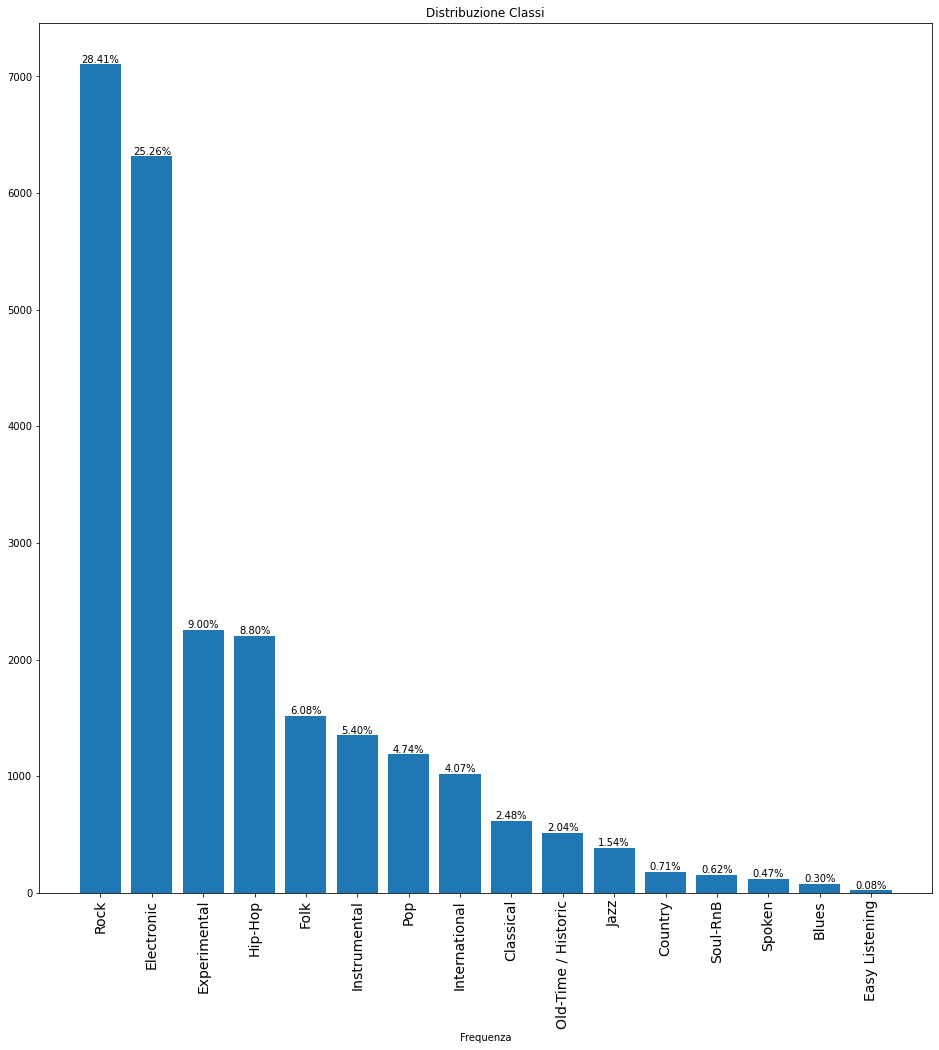

In [ ]:
class_distribution_histo(tracks_medium)

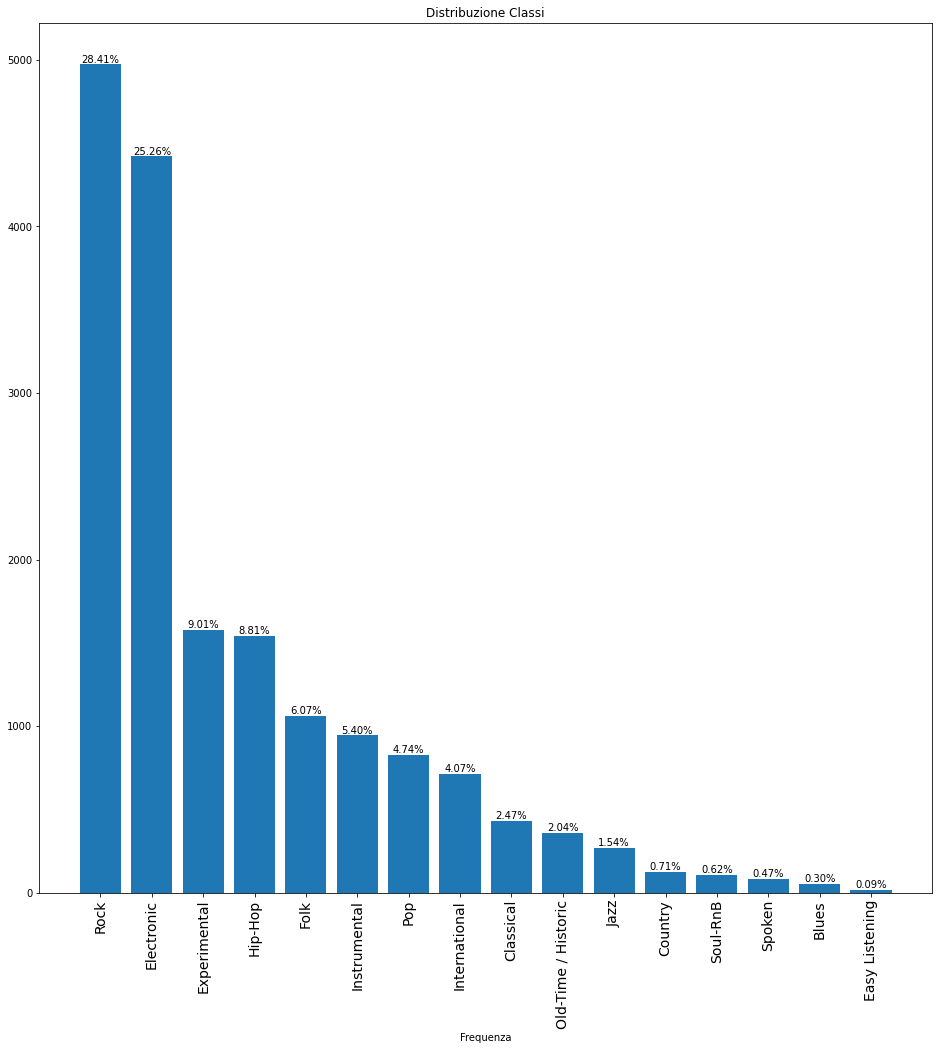

In [ ]:
class_distribution_histo(y_train)

In questa parte del notebook si effettua una piccola digressione per analizzare la composizione delle features. Di seguito si illustra innanzitutto la struttura:

In [ ]:
X.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
134           0.918445  0.674147  0.577818  1.281117  0.933746  0.078177   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
134         1.199204 -0.175223  0.925482  1.438509  ...  0.058766  0.016322   

feature                     zcr                                               \
statistics             kurtosis       max      mean    median  min      skew   
number            06         01        01        01        01   01        01   
track_id                                                                       
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.0  2.089872   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.0  1.716724   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.0  2.193303   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.0  3.542325   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.0  1.806106   

feature               
statistics       std  
number            01  
track_id              
2           0.061448  
3           0.069330  
5           0.044861  
10          0.040800  
134         0.054623  

[5 rows x 518 columns]

Il dataset consiste di 518 features estratte attraverso procedimenti di analisi tipici nei file audio. La maggior parte delle features derivano da diversi modi di ottenere uno spettrogramma del file audio ovvero una rappresenzatione dell'intensità in funzione della frequenza e del tempo. Tipicamente è ottenuto mediante una *Short Time Fourier Transform* (STFT), cioè una trasformata di Fourier applicate su porzioni non disgiunte del segnale. Questo permette appunto di ottenere uno spettro in funzione del tempo.
In genere l'intensità è riportata in scala logaritmica in maniera tale da avere un raffronto diretto con quanto percepito dall'uomo, dal momento che l'uomo percepisce le intensità non in maniera lineare ma logaritmica. Di seguito alcune features derivanti da spettrogrammi:

 - **Chroma features**: spettrogramma in cui nell'ordinata vengono riportate le frequenze relative alle 12 note della scala temperata. Nel dataset si hanno 3 diverse chroma features: *Chroma_cqt* e *Chroma_sft* ottenute tramite trasformata CQT e STFT rispettivamente e infine *Chroma_cens* che consiste in un particolare sottocampionamento della Chroma_cqt. Per ognuna delle 3 chroma features si hanno pertanto 12 distribuzioni delle intensità nel tempo relative alle 12 note, di queste nel dataset vengono riportati 7 indici statistici: i momenti mean, std, skew, kurtosis e median min e max. Un uso delle chroma features può essere quello di analizzare differenti interpretazioni di una stessa canzone.
 - **Mel Frequency Cepstrum Coefficient** (MFCC): gli MFCC passano innanzitutto da uno spettrogramma Mel, ovvero uno spettrogramma in cui anche le frequenze sono rappresentate in scala logaritmica, sempre con l'intento di avere una rappresentazione più vicina alla percezione dell'uomo (l'uomo percepisce anche le frequenze in scala logaritmica). La scala Mel viene usata per suddividere lo spettro in sottobande. I coefficienti sono calcolati attraverso la *Inverse Cosine Transform*. Sono molto utilizzati nella speech recognition e sono noti per avere un alto contenuto informativo. Nel dataset sono presenti i primi 20 coefficienti e per ognuno di essi si hanno gli stessi 7 indici statistici delle chroma features.
 - **Tonnetz**: è una chroma feature proiettata in una base a 6 dimensioni corrispondente a 3 particolari note ciascuna rappresentate ciascuna in due dimensioni.


 Sono presenti infine anche:

  - **Spectral Features**: consistono in diverse statistiche spettrali, come lo *spectral centroid* che rappresenta il centro di massa dello spettro, oppure lo *spectral roll-off* è la frequenza al di sotto della quale risiede una percentuale dello spettro totale. Sono presenti inoltre nel dataset la *spectral bandwidth* e lo *spectral contrast*.
  - **Root Mean Square Error**
  - **Zero Crossing Rate**

Di seguito si riportano due violin plot delle 16 classi per due diverse grandezze, la mediana dello spectral roll-off e la mediana del primo MFCC

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text major ticklabel objects>)

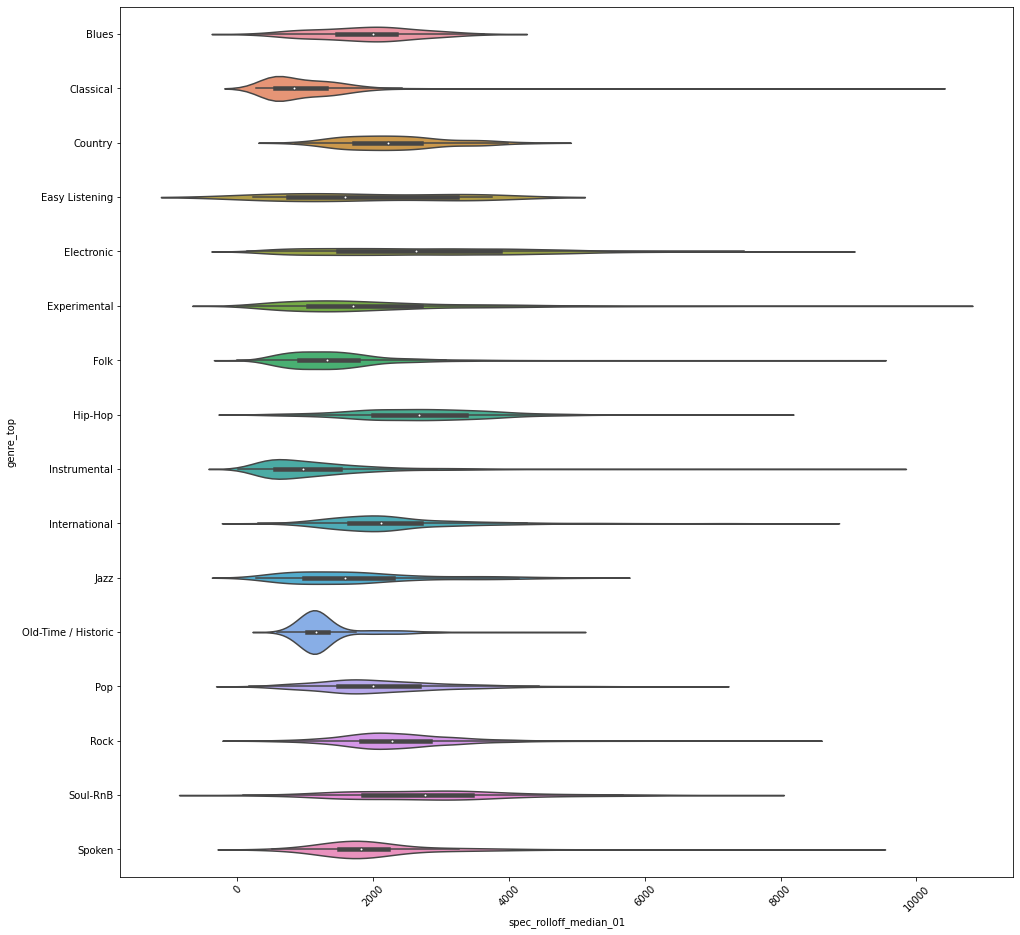

In [ ]:
sns.violinplot(data=X_y_not_encoded_and_scaled, x=("spectral_rolloff", "median","01") ,y = ("genre_top","genre_top","genre_top"))
plt.xlabel("spec_rolloff_median_01")
plt.ylabel("genre_top")
plt.xticks(rotation=45)

(array([-1200., -1000.,  -800.,  -600.,  -400.,  -200.,     0.,   200.,
          400.]), <a list of 9 Text major ticklabel objects>)

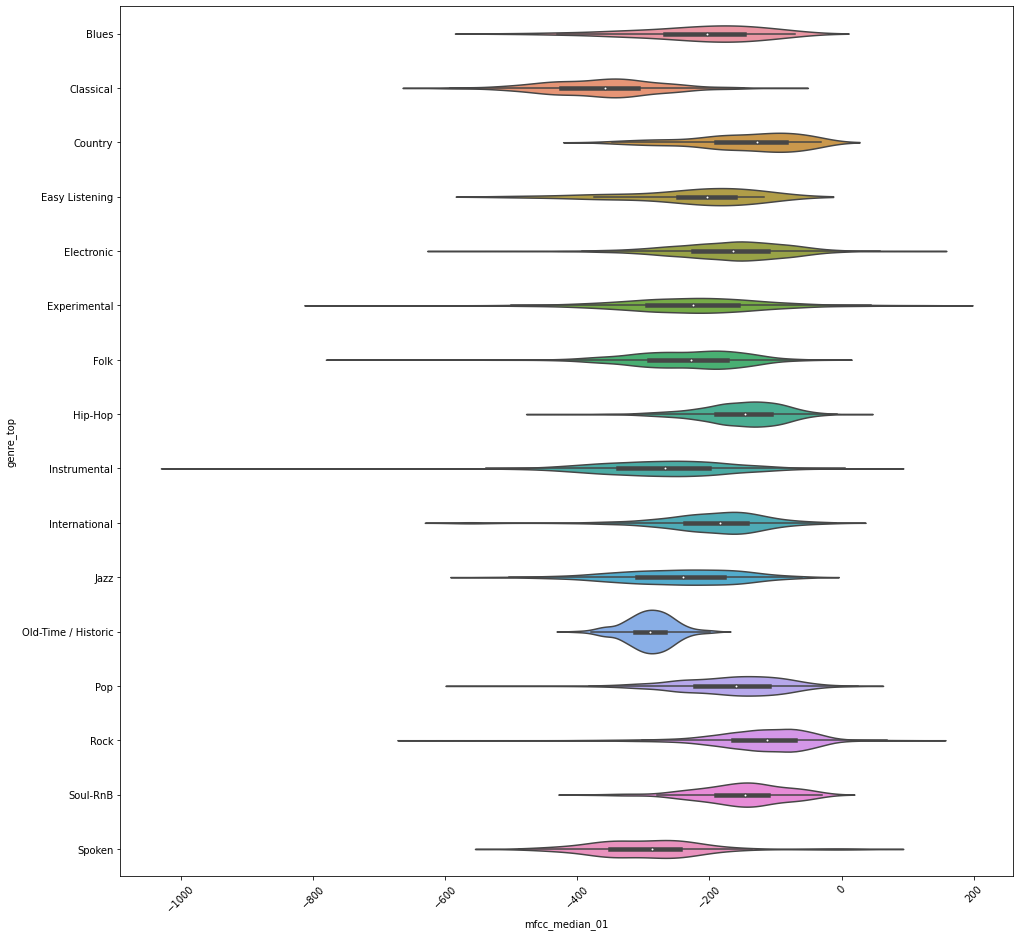

In [ ]:
sns.violinplot(data=X_y_not_encoded_and_scaled, x=("mfcc", "median","01") ,y = ("genre_top","genre_top","genre_top"))
plt.xlabel("mfcc_median_01")
plt.ylabel("genre_top")
plt.xticks(rotation=45)

<font size="7">**Preprocessing**</font>

Nella seguente sezione analizzerò delle tecniche di riduzione della dimensionalità, l'intento è di esplorare i risultati dei metodi che saranno poi utilizzati nella model selection attraverso una cross validation. Si è fatto uso di:

- *feature selection*: Variance Threshold e Mutual Information
- *feature exctraction*: PCA

Le tecniche di feature selection si suddividono in 3 categorie:
- **filter**: in cui si fa uso di un indice statistico per determinare il miglior subset di features, ovvero il sottoinsieme più discriminante e informativo.
- **wrapper**: dove attraverso il fitting di un modello sul dataset si effettua una ricerca *greedy* tra tutte le possibili combinazioni di features che vengono valutate tramite un criterio scelto.
- **embedded**: la feature selection è racchiusa nel processo di addestramento del modello, un tipico esempio è la Lasso Regolarization in cui al variare dell'iperparamentro lambda nella funzione di costo si ha una variazione delle features presenti nel modello.

Mentre per la feature extraction le tecniche si suddividono in due categorie che si differenziano per il meccanismo in cui il dataset è proiettato in un sottospazio a dimensione ridotta:

- proiezione lineare di cui la PCA è il metodo più diffuso, la proiezione avviene su iperpiani
- proiezione non lineare quale ad esempio *manifold learning* dove la proiezione avviene su una ipersuperficie generica con determinate caratteristiche topologiche.

La scelta di tecniche filter è legata al minor costo computazionale e ad una facile implementazione nella GridSearchCV. Di seguito si è applicato la Variance Threshold con una soglia pari a 0.1, si può osservare che secondo tale criterio vengono sostanzialmente scartate le chroma features e i tonnentz. 





In [ ]:
vt_thresh = VarianceThreshold(threshold = 0.1)
var_threshed = vt_thresh.fit(X_train)

features_var_threshed = [column for column in X.columns if column not in X_train.columns[var_threshed.get_support()]]
features_not_var_threshed = [column for column in X.columns if column in X_train.columns[var_threshed.get_support()]]
cols = pd.MultiIndex.from_tuples(features_not_var_threshed, names = ["feature", "statistics","number"])
X_train_var_threshed = pd.DataFrame(vt_thresh.transform(X_train), columns = cols)
X_train_var_threshed.index.name = "track_id"

X_test_var_threshed = pd.DataFrame(vt_thresh.transform(X_test), columns = cols)
X_test_var_threshed.index.name = "track_id"
print("La variance threshold scarta un numero di features pari a:",len(features_var_threshed))
print("Ovvero le seguenti:")
features_var_threshed

La variance threshold scarta un numero di features pari a: 226
Ovvero le seguenti:


[('chroma_cens', 'max', '01'),
 ('chroma_cens', 'max', '02'),
 ('chroma_cens', 'max', '03'),
 ('chroma_cens', 'max', '04'),
 ('chroma_cens', 'max', '05'),
 ('chroma_cens', 'max', '06'),
 ('chroma_cens', 'max', '07'),
 ('chroma_cens', 'max', '08'),
 ('chroma_cens', 'max', '09'),
 ('chroma_cens', 'max', '10'),
 ('chroma_cens', 'max', '11'),
 ('chroma_cens', 'max', '12'),
 ('chroma_cens', 'mean', '01'),
 ('chroma_cens', 'mean', '02'),
 ('chroma_cens', 'mean', '03'),
 ('chroma_cens', 'mean', '04'),
 ('chroma_cens', 'mean', '05'),
 ('chroma_cens', 'mean', '06'),
 ('chroma_cens', 'mean', '07'),
 ('chroma_cens', 'mean', '08'),
 ('chroma_cens', 'mean', '09'),
 ('chroma_cens', 'mean', '10'),
 ('chroma_cens', 'mean', '11'),
 ('chroma_cens', 'mean', '12'),
 ('chroma_cens', 'median', '01'),
 ('chroma_cens', 'median', '02'),
 ('chroma_cens', 'median', '03'),
 ('chroma_cens', 'median', '04'),
 ('chroma_cens', 'median', '05'),
 ('chroma_cens', 'median', '06'),
 ('chroma_cens', 'median', '07'),
 ('chr

Alla Variance Threshold fa seguito la Mutual Information, una tecnica che si basa sull'incertezza, ovvero quanto la conoscenza di una quantità riduce l'incertezza su una seconda quantità. E' legata al'entropia di una variabile casuale.

In [ ]:
scaler_x_var = StandardScaler().fit(X_train_var_threshed)
X_train_var_threshed_scaled = pd.DataFrame(scaler_x_var.transform(X_train_var_threshed), columns = X_train_var_threshed.columns)
X_test_var_threshed_scaled = pd.DataFrame(scaler_x_var.transform(X_test_var_threshed), columns = X_test_var_threshed.columns)

select_after_var = SelectKBest(mutual_info_classif,k=160)
mutual_after_var = select_after_var.fit(X_train_var_threshed_scaled,y_train_encoded)
feature_mutual_after_var = [column for column in X_train_var_threshed_scaled.columns if column in X_train_var_threshed_scaled.columns[mutual_after_var.get_support()]]
cols_mutual_after_var = pd.MultiIndex.from_tuples(feature_mutual_after_var, names = ["feature", "statistics","number"])
X_train_var_mutual_scaled = pd.DataFrame(select_after_var.transform(X_train_var_threshed_scaled), columns = cols_mutual_after_var)
X_train_var_mutual_scaled.index.name = "track_id"

X_test_var_mutual_scaled = pd.DataFrame(select_after_var.transform(X_test_var_threshed_scaled), columns = cols_mutual_after_var)
X_test_var_mutual_scaled.index.name = "track_id"

Di seguito si possono osservare le 50 features più rilevanti selezionate dal metodo, non sorprende che tra queste vi siano i primi coefficienti MFCC con gli indici statistici principali.

In [ ]:
dict_importances = {}
for i in range(len(mutual_after_var.scores_)):
  dict_importances[X_train_var_threshed.columns[i]] = mutual_after_var.scores_[i]
sorted(dict_importances, key=dict_importances.get, reverse=True)[:50]

[('mfcc', 'median', '01'),
 ('mfcc', 'median', '03'),
 ('mfcc', 'mean', '01'),
 ('spectral_contrast', 'median', '02'),
 ('mfcc', 'max', '01'),
 ('spectral_contrast', 'mean', '04'),
 ('mfcc', 'max', '04'),
 ('spectral_rolloff', 'median', '01'),
 ('spectral_contrast', 'median', '03'),
 ('spectral_contrast', 'median', '04'),
 ('spectral_bandwidth', 'median', '01'),
 ('mfcc', 'mean', '03'),
 ('spectral_rolloff', 'mean', '01'),
 ('spectral_contrast', 'mean', '02'),
 ('spectral_contrast', 'mean', '03'),
 ('spectral_bandwidth', 'mean', '01'),
 ('spectral_rolloff', 'kurtosis', '01'),
 ('spectral_centroid', 'std', '01'),
 ('mfcc', 'median', '04'),
 ('spectral_rolloff', 'std', '01'),
 ('spectral_centroid', 'mean', '01'),
 ('spectral_centroid', 'median', '01'),
 ('mfcc', 'mean', '04'),
 ('spectral_contrast', 'max', '07'),
 ('spectral_rolloff', 'skew', '01'),
 ('mfcc', 'max', '06'),
 ('spectral_contrast', 'median', '05'),
 ('mfcc', 'std', '14'),
 ('mfcc', 'max', '08'),
 ('mfcc', 'max', '10'),
 ('s

In maniera analoga invece si possono osservare alcune features che vengono scartate, tra queste compaiono anche gli MFCC più alti con momenti di terzo e quarto ordine.

In [ ]:
dict_importances = {}
for i in range(len(mutual_after_var.scores_)):
  dict_importances[X_train_var_threshed.columns[i]] = mutual_after_var.scores_[i]
sorted(dict_importances, key=dict_importances.get)[:50]

[('tonnetz', 'skew', '03'),
 ('chroma_cqt', 'skew', '12'),
 ('tonnetz', 'skew', '04'),
 ('tonnetz', 'skew', '01'),
 ('chroma_cens', 'skew', '12'),
 ('chroma_cens', 'kurtosis', '05'),
 ('chroma_cens', 'skew', '01'),
 ('tonnetz', 'kurtosis', '02'),
 ('chroma_cens', 'skew', '08'),
 ('mfcc', 'kurtosis', '15'),
 ('mfcc', 'kurtosis', '09'),
 ('chroma_cens', 'skew', '07'),
 ('tonnetz', 'skew', '02'),
 ('chroma_cens', 'skew', '05'),
 ('tonnetz', 'skew', '05'),
 ('chroma_cens', 'skew', '02'),
 ('chroma_cqt', 'kurtosis', '12'),
 ('chroma_cqt', 'skew', '11'),
 ('chroma_cens', 'skew', '11'),
 ('tonnetz', 'skew', '06'),
 ('chroma_cens', 'skew', '09'),
 ('mfcc', 'kurtosis', '08'),
 ('chroma_cens', 'kurtosis', '06'),
 ('chroma_cens', 'skew', '10'),
 ('chroma_cqt', 'kurtosis', '07'),
 ('mfcc', 'kurtosis', '10'),
 ('mfcc', 'kurtosis', '11'),
 ('mfcc', 'kurtosis', '05'),
 ('chroma_cens', 'skew', '04'),
 ('mfcc', 'kurtosis', '13'),
 ('chroma_cens', 'kurtosis', '09'),
 ('chroma_cqt', 'kurtosis', '10'),
 (

Nella cella seguente invece si applica la Principal Component Analysis al dataset standardizzato. Il numero di componenti scelte è pari al minor numero di autovettori per cui la varianza è maggiore del 95% della varianza totale. In tal caso è pari a 211, ovvero si sono scelti i 211 autovettori corrispondenti ai 211 autovalori più grandi della matrice di covarianza del dataset.

(17500, 211)

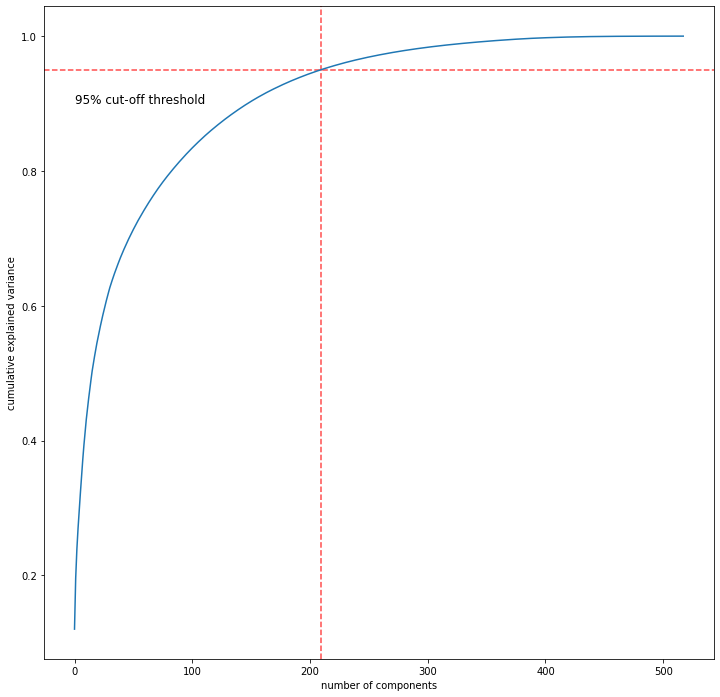

In [ ]:
pca_train_scaled = PCA().fit(X_train_scaled)

n_components = np.abs(np.cumsum(pca_train_scaled.explained_variance_ratio_)  - 0.95).argmin()

plt.figure(figsize=(12,12))
plt.axhline(y=0.95, color='red', alpha = 0.7, ls = "--")
plt.text(0.5, 0.90, '95% cut-off threshold', color = 'black', fontsize=12)
plt.axvline(n_components, color ="r", alpha = 0.7, ls = "--")
plt.plot(np.cumsum(pca_train_scaled.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

pca_train_scaled = PCA(.95).fit(X_train_scaled)
X_pca_train_scaled = pca_train_scaled.transform(X_train_scaled)
X_pca_test_scaled = pca_train_scaled.transform(X_test_scaled)
X_pca_train_scaled.shape

<font size="7">**Model Selection**</font>

In questa sezione si effettua la selezione e la valutazione dei modelli scelti. Come anticipato in precedenza saranno valutati KNN,SVC con kernel rbf e una rete neurale di tipo MLP su tre diversi rappresentazioni del dataset:

- Dataset ridotto attraverso PCA
- Dataset ridotto attraverso Variance Threshold e Mutual Information
- Dataset ridotto attraverso PCA e sovraccampionato attraverso SMOTE.

Per i primi due modelli si effettua una cross validation con una breve esplorazione degli iperparametri relativi. Mentre per la rete neurale non è stata effettuata una cross validation per cercare i parametri ottimali.

Come si può vedere dalla cella sottostante si è utilizzato per le procedure di cross validation innanzitutto una StratifiedKFold necessaria per dataset sbilanciati, in maniera tale che la distribuzione si conservi tra train e validation data. Inoltre si è adottata l'implementazione GridSearchCV con Pipeline in maniera tale che le fasi di preprocessing quali standardizzazione, riduzione dimensionalità e oversampling coinvolgessero esclusivamente i dati di addestramento e non quelli di validazione. Così facendo si evita il *data leakage* e stime ottimistiche del modello, sebbene può capitare che tale fenomeno non abbia una grande influenza.
Tale approccio ha tuttavia creato qualche problema nell'implementazione di SMOTE, innanzitutto SMOTE è una tecnica di oversampling in cui, nella versione base, vengono creati dati sintetici a partire da un modello KNN. La creazione di dati artificial ha lo scopo di ribilanciare le classi ed eventualmente portare a performance migliori del modello. In SMOTE è possibile adottare diverse strategie di bilanciamento, si è deciso di adottare un resampling personalizzato tramite dizionario per evitare che il numero di campioni crescesse eccessivamente tuttavia non sono riuscito a rendere dinamico il tutto in funzione dei dati in entrata. Pertanto si è adottata una soluzione poco elegante tramite valori fissi.

Essendo un dataset fortemente sbilanciato, valutare il modello tramite la tipica metrica accuracy può essere fuorviante pertanto si è optato per il Mean F1 Score, che è anche una delle metriche suggerite dagli autori della competizione. Il Mean F1 Score, che in notazione sklearn è indicato come macro, tratta le classi in maniera equivalente, facendo una media non pesata tra gli F1 score delle singole classi. Di conseguenza risulta essere una metrica più adatta a valutare le performance del modello per le classi minoritarie rispetto all'F1 Score Micro o Weigthed Average.
<br>

In genere si possono osservare delle performance non brillanti dei modelli ma credo che questo possa essere ricondotto alla difficoltà del dataset e del task in generale.

<font size="5">**KNN**</font>

Modello di classificazione non parametrico in cui la previsione viene effettuata tramite una funzione di similitudine che prende il nome di kernel. Nel caso di KNN il kernel valuta la distanza tra il punto considerato e i punti del dataset nello spazio delle features, il numero di punti considerati è fornito tramite un iperparametro del modello e l'assegnazione del target, nella versione base, avviene tramite un meccanismo di maggioranza. E' un modello che può risentire della *curse of dimensionality*.

In [ ]:
pca = PCA(.95)
zscore = StandardScaler()
KNN = KNeighborsClassifier(n_jobs = -1)


cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe = Pipeline(steps=[("zscore", zscore), ("pca", pca), ("KNN", KNN)])
param_grid = {
    "KNN__n_neighbors": [3,5,25,60,100],
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1)
search.fit(X_train,y_train_encoded)



Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('zscore', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('KNN',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'KNN__n_neighbors': [3, 5, 25, 60, 100]},
             return_train_score=True, scoring='f1_macro', verbose=1)

In [ ]:
best_knn_pca = search.best_estimator_
search.best_params_

{'KNN__n_neighbors': 5}

Si può osservare nell'underfitting generale come il modello migliore sia comunque il modello che ha più divario tra dati di addestramento e validazione

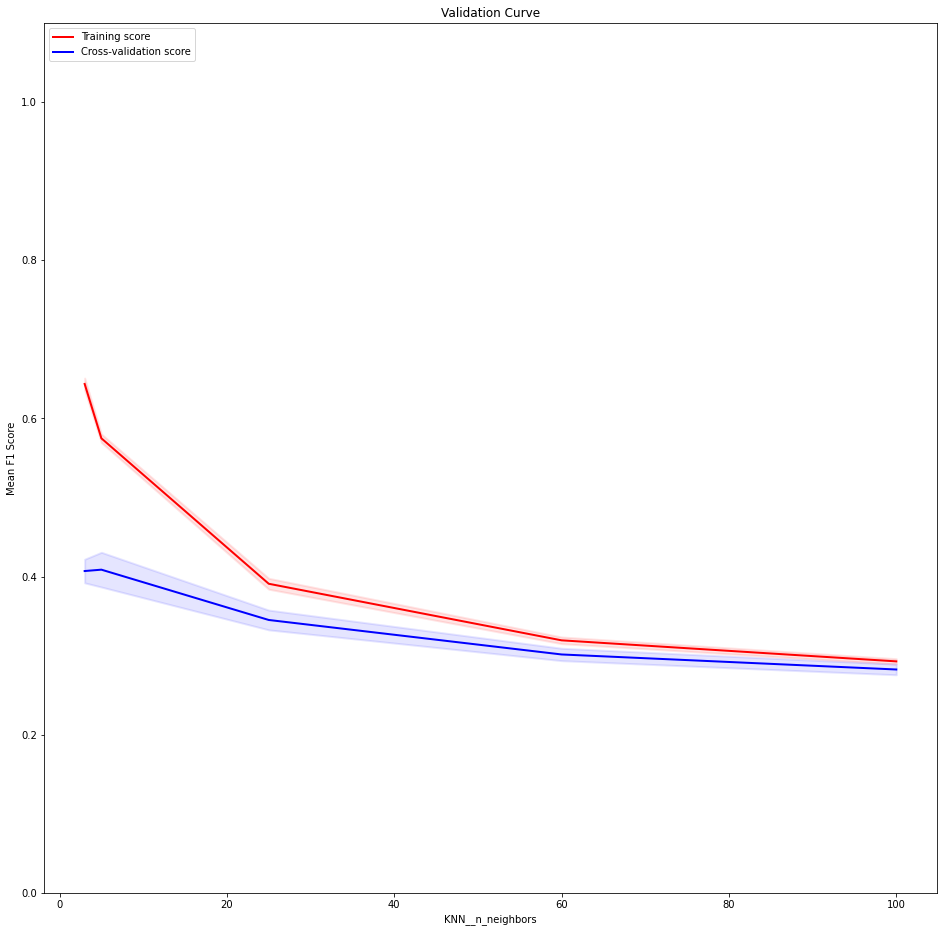

In [ ]:
plot_validation_curve(search,"KNN__n_neighbors")

In [ ]:
y_pred_test_best_knn_pca = best_knn_pca.predict(X_test)
y_pred_train_best_knn_pca = best_knn_pca.predict(X_train)

print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_knn_pca)))

                     precision    recall  f1-score   support

              Blues       0.15      0.23      0.18        22
          Classical       0.52      0.82      0.64       186
            Country       0.23      0.52      0.32        54
     Easy Listening       0.14      0.17      0.15         6
         Electronic       0.65      0.58      0.62      1894
       Experimental       0.45      0.23      0.31       675
               Folk       0.46      0.56      0.50       456
            Hip-Hop       0.48      0.56      0.52       660
       Instrumental       0.54      0.26      0.35       405
      International       0.42      0.50      0.46       305
               Jazz       0.36      0.33      0.34       115
Old-Time / Historic       0.87      0.95      0.91       153
                Pop       0.30      0.13      0.18       356
               Rock       0.67      0.83      0.74      2131
           Soul-RnB       0.67      0.26      0.38        46
             Spoken    

In [ ]:
f1_score_train = {}
f1_score_test = {}
f1_score_train["knn_pca"] = f1_score(y_train_encoded,y_pred_train_best_knn_pca, average='macro')
f1_score_test["knn_pca"] = f1_score(y_test_encoded, y_pred_test_best_knn_pca, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["knn_pca"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["knn_pca"]))

mean f1_score su dati addestramento: 0.589
mean f1_score su dati test:  0.435


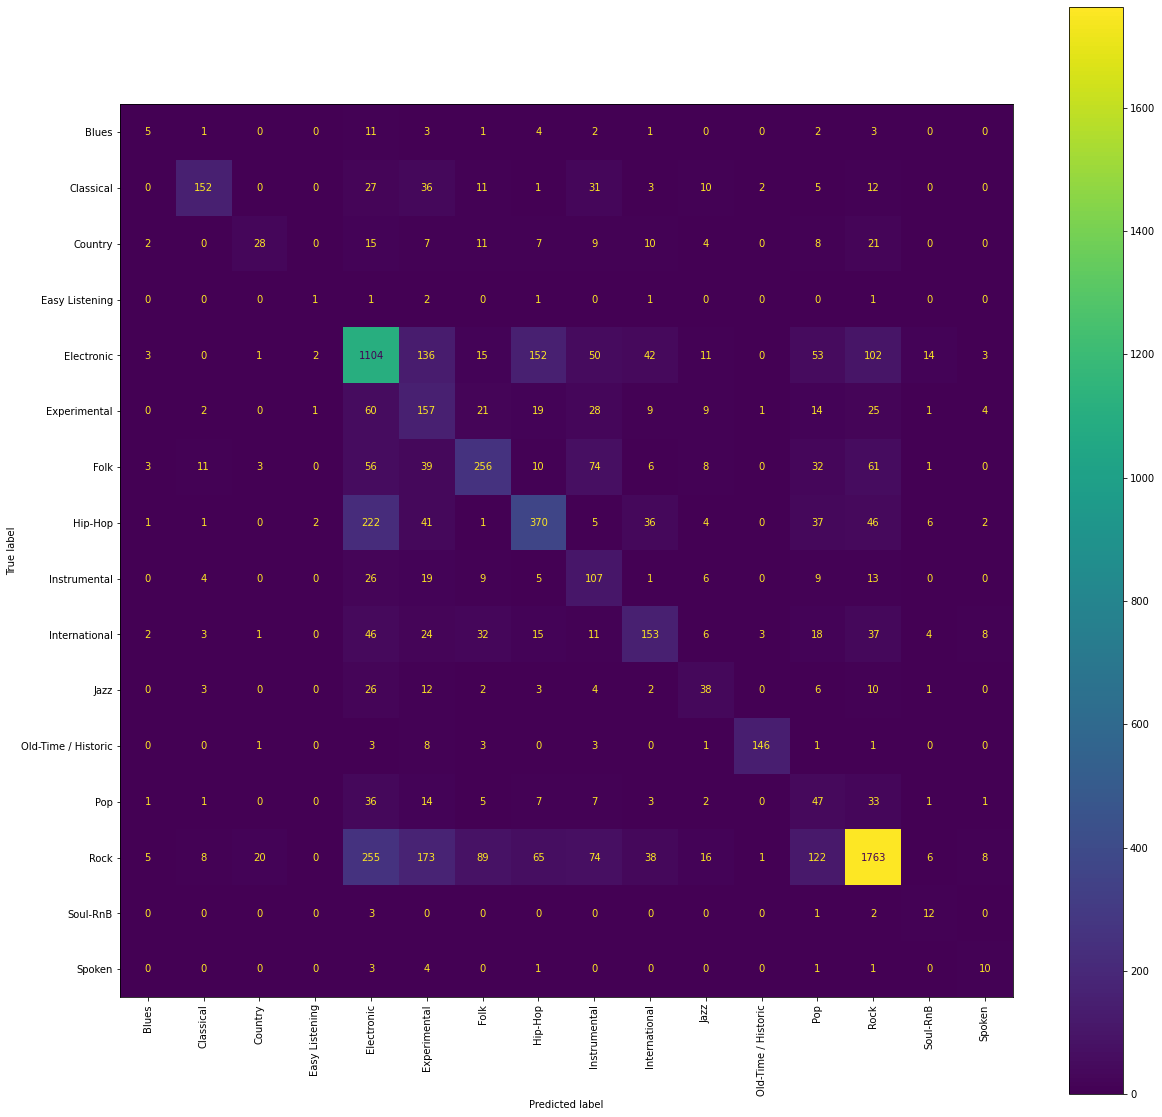

In [ ]:
conf_mat = ConfusionMatrixDisplay(confusion_matrix (y_pred_test_best_knn_pca, y_test_encoded),display_labels=converter.inverse_transform(best_knn_pca.classes_))
fig, ax = plt.subplots(figsize=(20,20))
conf_mat.plot(ax=ax)
plt.xticks(rotation='vertical', fontsize = 10)
plt.show()

In [ ]:
var_thresh = VarianceThreshold(threshold = 0.1)
mutual = SelectKBest(mutual_info_classif, k = 160)
pipe = Pipeline(steps=[("var_thresh", var_thresh), ("zscore", zscore), ("mutual", mutual), ("KNN", KNN)])

param_grid = {
    "KNN__n_neighbors": [3,5,25,60,100],
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1)
search.fit(X_train,y_train_encoded)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('var_thresh',
                                        VarianceThreshold(threshold=0.1)),
                                       ('zscore', StandardScaler()),
                                       ('mutual',
                                        SelectKBest(k=160,
                                                    score_func=<function mutual_info_classif at 0x7fbf18312f80>)),
                                       ('KNN',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'KNN__n_neighbors': [3, 5, 25, 60, 100]},
             return_train_score=True, scoring='f1_macro', verbose=1)

In [ ]:
best_knn_var_mutual = search.best_estimator_
search.best_params_

{'KNN__n_neighbors': 3}

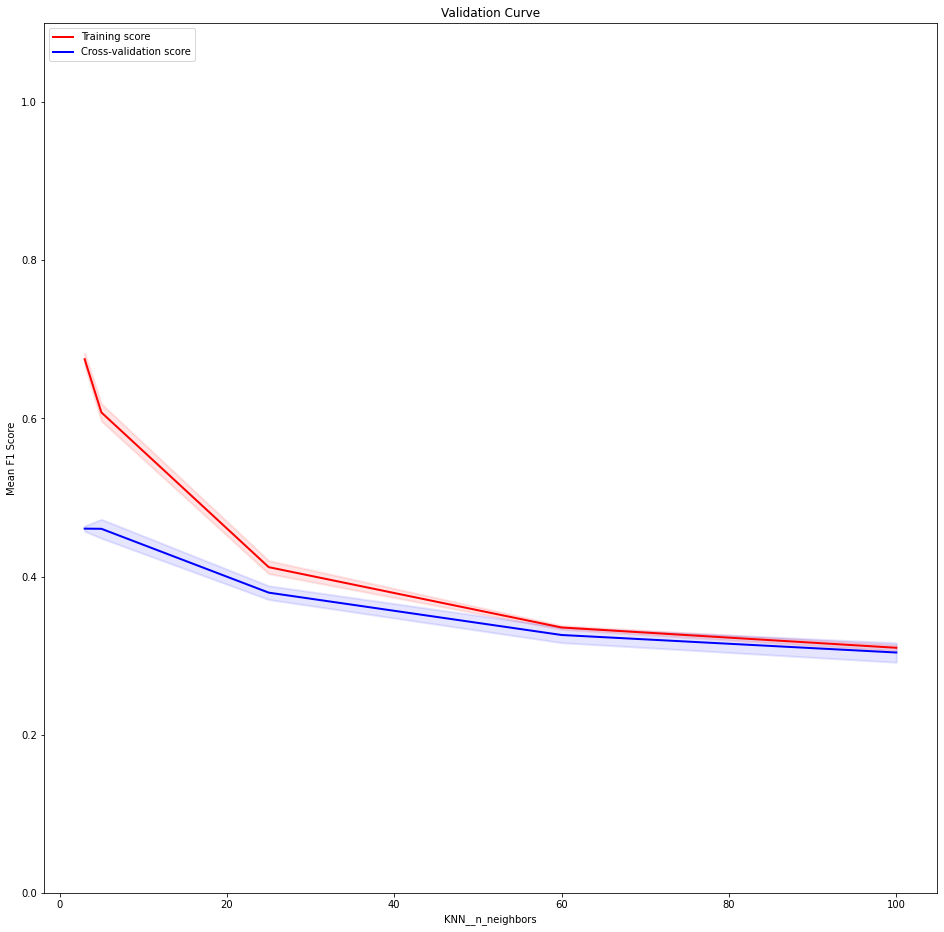

In [ ]:
plot_validation_curve(search,"KNN__n_neighbors")

In [ ]:
y_pred_test_best_knn_var_mutual = best_knn_var_mutual.predict(X_test)
y_pred_train_best_knn_var_mutual = best_knn_var_mutual.predict(X_train)

print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_knn_var_mutual)))

                     precision    recall  f1-score   support

              Blues       0.18      0.36      0.24        22
          Classical       0.48      0.87      0.62       186
            Country       0.20      0.63      0.30        54
     Easy Listening       0.18      0.33      0.24         6
         Electronic       0.63      0.68      0.65      1894
       Experimental       0.45      0.22      0.30       675
               Folk       0.54      0.63      0.58       456
            Hip-Hop       0.53      0.60      0.56       660
       Instrumental       0.54      0.36      0.43       405
      International       0.54      0.59      0.56       305
               Jazz       0.50      0.31      0.39       115
Old-Time / Historic       0.95      0.96      0.95       153
                Pop       0.49      0.16      0.24       356
               Rock       0.76      0.82      0.79      2131
           Soul-RnB       0.46      0.28      0.35        46
             Spoken    

In [ ]:
f1_score_train["knn_pca_var_mutual"] = f1_score(y_train_encoded,y_pred_train_best_knn_var_mutual, average='macro')
f1_score_test["knn_pca_var_mutual"] = f1_score(y_test_encoded, y_pred_test_best_knn_var_mutual, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["knn_pca_var_mutual"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["knn_pca_var_mutual"]))

mean f1_score su dati addestramento: 0.677
mean f1_score su dati test:  0.486


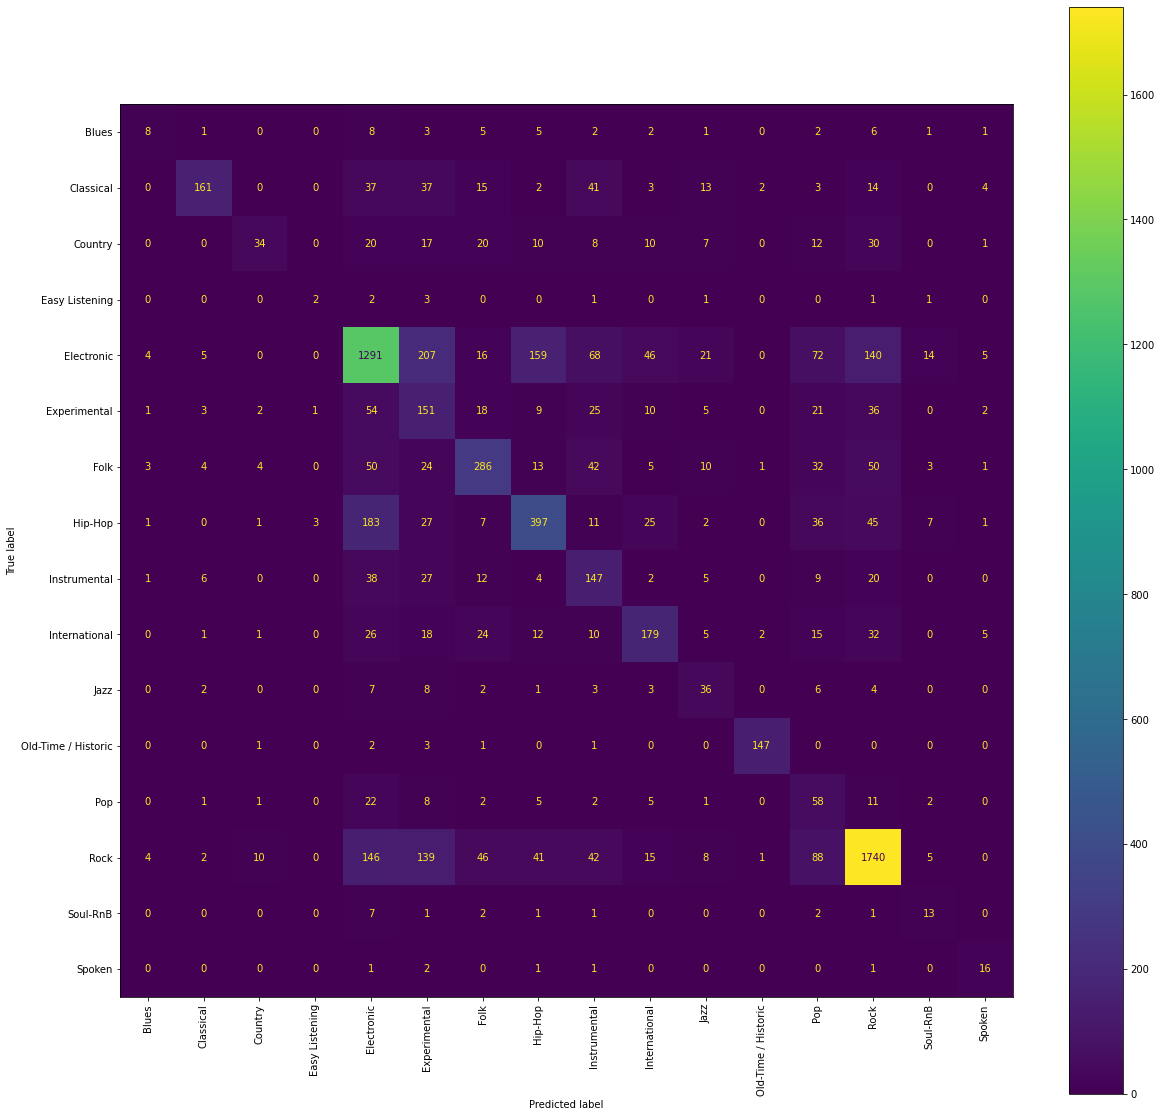

In [ ]:
conf_mat = ConfusionMatrixDisplay(confusion_matrix (y_pred_test_best_knn_var_mutual, y_test_encoded),display_labels=converter.inverse_transform(best_knn_var_mutual.classes_))
fig, ax = plt.subplots(figsize=(20,20))
conf_mat.plot(ax=ax)
plt.xticks(rotation='vertical', fontsize = 10)
plt.show()

In [ ]:
dictio_resampling_1,size_1 = resampling(X_train,y_train_encoded,mode = 1)
dictio_resampling_2,size_2 = resampling(X_train,y_train_encoded,mode = 2)
dictio_resampling_3,size_3 = resampling(X_train,y_train_encoded,mode = 3)
train_sizes = [size_1,size_2,size_3]

smote = SMOTE()

pipe = smotepipeline(steps=[("zscore", zscore), ("pca", pca),("smote",smote),("KNN", KNN)])
param_grid = {
   "smote__sampling_strategy": [dictio_resampling_1,dictio_resampling_2,dictio_resampling_3],
    "KNN__n_neighbors": [3,5,25,60,100],
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1)
search.fit(X_train,y_train_encoded)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('zscore', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE()),
                                       ('KNN',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'KNN__n_neighbors': [3, 5, 25, 60, 100],
                         'smote__sampling_strategy': [{0: 1200, 1: 1200,
                                                       2: 1200, 3: 1200,
                                                       4: 4420, 5: 1576,
                                                       6: 1200, 7: 1541,
                                                       8: 1200, 9: 1200,
                                                       10: 1200, 11: 1200,
                                                       12: 1200, 13: 4972,
                    

In [ ]:
best_knn_pca_smote = search.best_estimator_
search.best_params_

{'KNN__n_neighbors': 3,
 'smote__sampling_strategy': {0: 1500,
  1: 1500,
  2: 1500,
  3: 1500,
  4: 4420,
  5: 2750,
  6: 1500,
  7: 2750,
  8: 1500,
  9: 1500,
  10: 1500,
  11: 1500,
  12: 1500,
  13: 4972,
  14: 1500,
  15: 1500}}

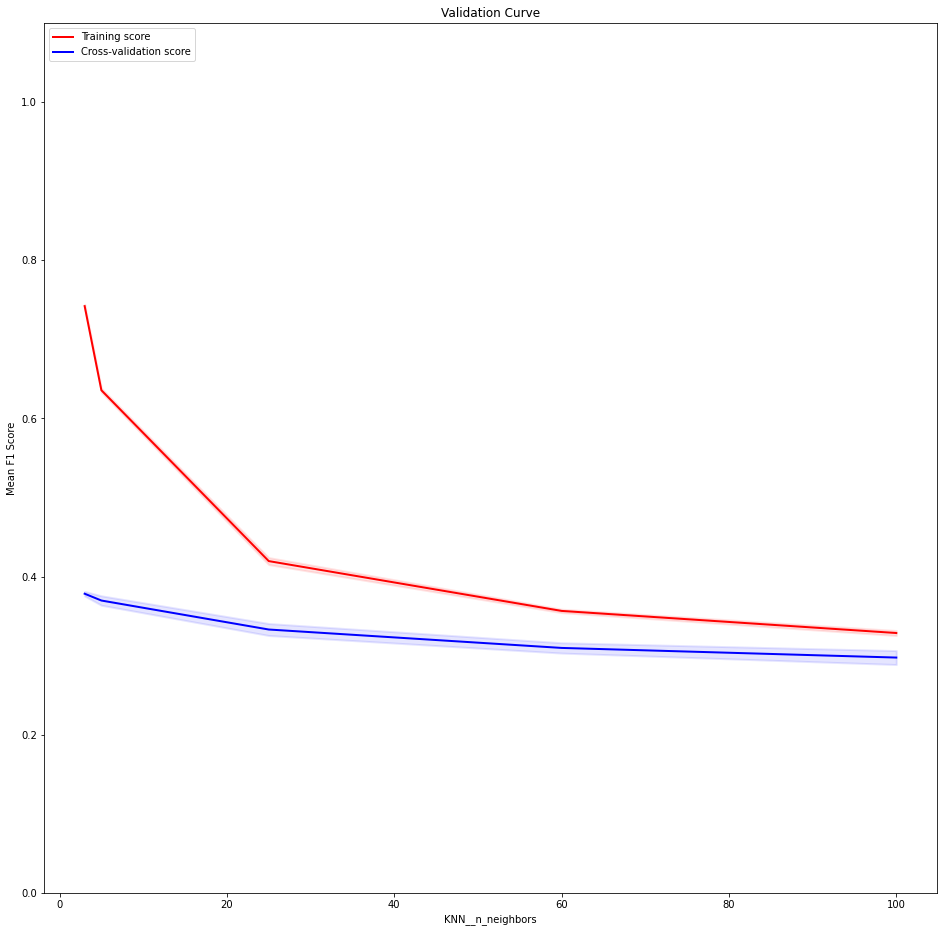

In [ ]:
plot_validation_curve(search,"KNN__n_neighbors")

Di seguito è graficata la curva di apprendimento relativo al parametro k = 3, ovvero le performance del modello al variare della dimensione del dataset

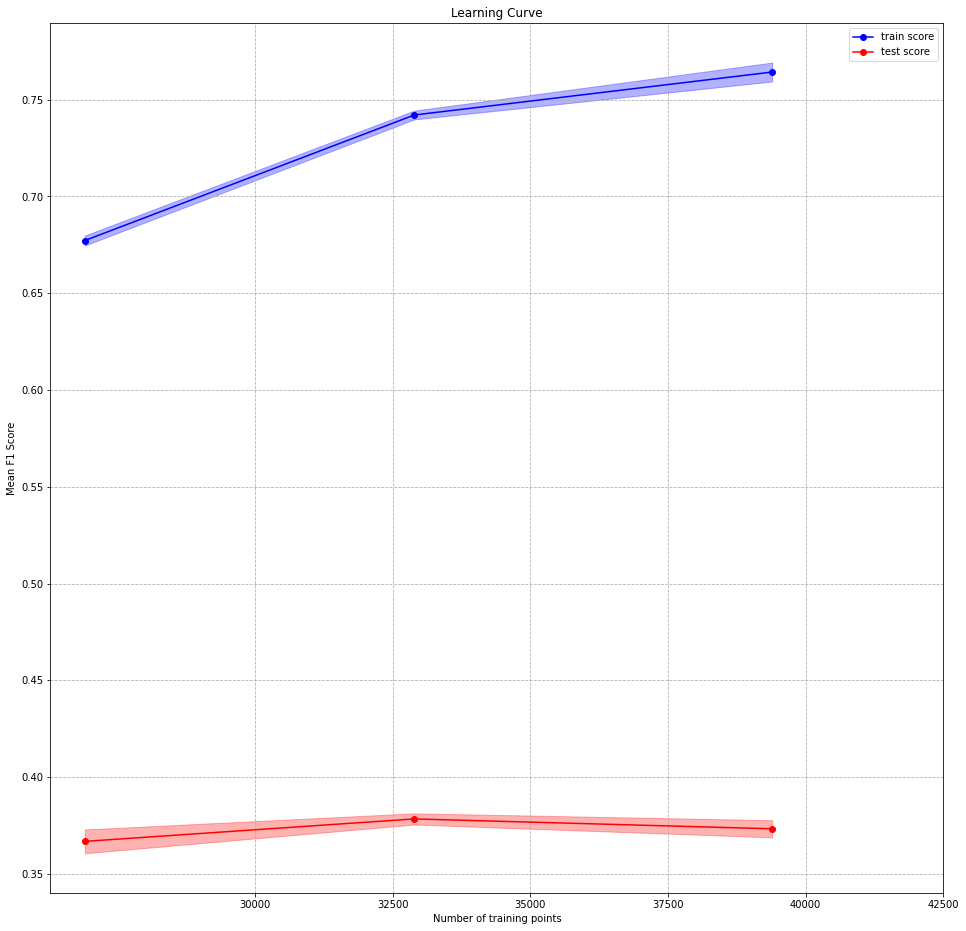

In [ ]:
plot_learning_curve(train_sizes,search,"KNN__n_neighbors",3)

In [ ]:
y_pred_test_best_knn_pca_smote = best_knn_pca_smote.predict(X_test)
y_pred_train_best_knn_pca_smote = best_knn_pca_smote.predict(X_train)

print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_knn_pca_smote)))

                     precision    recall  f1-score   support

              Blues       0.05      0.50      0.08        22
          Classical       0.48      0.84      0.61       186
            Country       0.08      0.87      0.15        54
     Easy Listening       0.02      0.33      0.03         6
         Electronic       0.71      0.28      0.40      1894
       Experimental       0.33      0.33      0.33       675
               Folk       0.44      0.42      0.43       456
            Hip-Hop       0.37      0.56      0.44       660
       Instrumental       0.44      0.30      0.36       405
      International       0.35      0.58      0.43       305
               Jazz       0.16      0.61      0.26       115
Old-Time / Historic       0.86      0.98      0.92       153
                Pop       0.19      0.21      0.20       356
               Rock       0.87      0.47      0.61      2131
           Soul-RnB       0.08      0.57      0.14        46
             Spoken    

In [ ]:
f1_score_train["knn_pca_smote"] = f1_score(y_train_encoded,y_pred_train_best_knn_pca_smote, average='macro')
f1_score_test["knn_pca_smote"] = f1_score(y_test_encoded, y_pred_test_best_knn_pca_smote, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["knn_pca_smote_3_mode_2"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["knn_pca_smote_3_mode_2"]))

mean f1_score su dati addestramento: 0.644
mean f1_score su dati test:  0.360


<font size="5">**SVC**</font>

*Il Support Vector Classificator* è un modello di classificazione lineare parametrico e non probabilistico (in sklearn è tuttavia possibile ottenere un output probabilistico tramite l'abilitazione di alcune funzioni che fanno uso di cross validation). Si basa sul concetto di margine ovvero la distanza tra la superficie di separazione e il dato nello spazio delle features più vicino ad essa. Come kernel si è scelto il *Radial Basis Function*:

$$K(\vec{x},\vec{y})=exp(-\gamma||\vec{x}-\vec{y}||^2)$$
<br>
Il modello oltre a l'iperparametro γ possiede un termine di regolarizzazione C la cui forza di regolarizzazione è inversamente proporzionale al valore del parametro. Alti valori di C comportano margini maggiori. Si osservano in tal senso le curve di validazione.

Due dei tre modelli, qui riportati, sono stati allentati su un altro notebook e sono stati importati i risultati. E' stato comunque riportato il codice.

In [ ]:
SVC = sklearn.svm.SVC(kernel='rbf')

pipe = Pipeline(steps=[("zscore", zscore), ("pca", pca), ("SVC", SVC)])
param_grid = {
    "SVC__C": [1,5,8],
    "SVC__gamma": [0.001,0.0005,0.00075]
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1, n_jobs = -1)
search.fit(X_train,y_train_encoded)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('zscore', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.5, 1, 2.5],
                         'SVC__gamma': [0.01, 0.005, 0.001]},
             return_train_score=True, scoring='f1_macro', verbose=1)

In [ ]:
results_svc_var_mutual = pd.read_csv("/content/drive/MyDrive/results_SVC_pca.csv", index_col = [0])
best_param =results_svc_var_mutual.loc[results_svc_var_mutual["rank_test_score"] == 1, ["param_SVC__C", "param_SVC__gamma"]]
best_param

,param_SVC__C,param_SVC__gamma
6,8,0.001


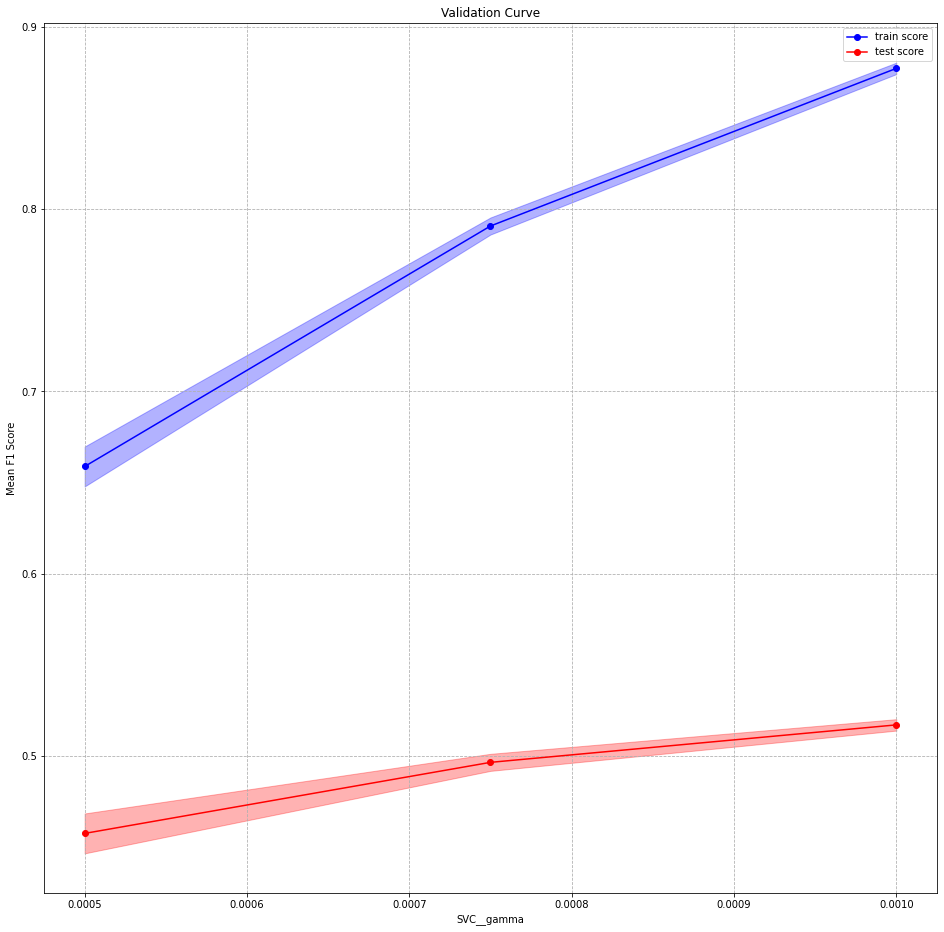

In [ ]:
plot_validation_curve_from_df(results_svc_var_mutual,"SVC__C", 8, "SVC__gamma")

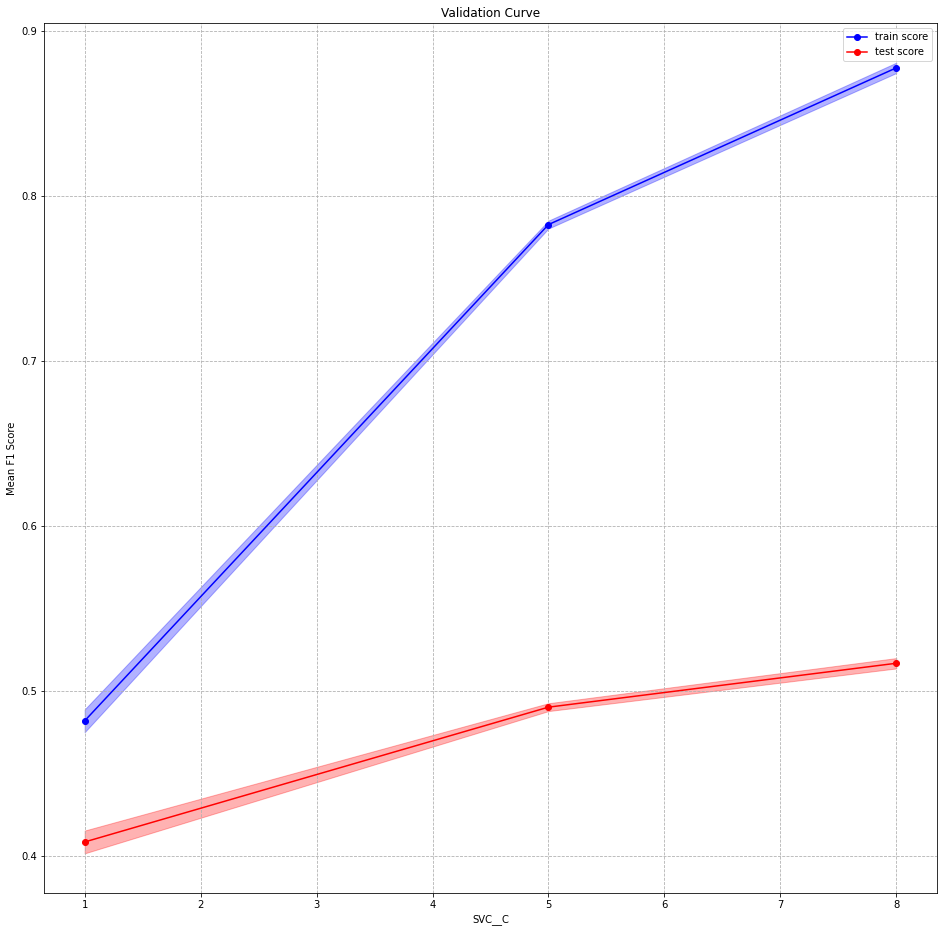

In [ ]:
plot_validation_curve_from_df(results_svc_var_mutual,"SVC__gamma", 0.001, "SVC__C")

In [ ]:
y_pred_test_best_svc_pca = pd.read_csv("/content/drive/MyDrive/y_pred_test_SVC_pca_df.csv", header = None)
y_pred_train_best_svc_pca = pd.read_csv("/content/drive/MyDrive/y_pred_train_SVC_pca_df.csv",  header = None)


print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_svc_pca)))

                     precision    recall  f1-score   support

              Blues       1.00      0.14      0.24        22
          Classical       0.81      0.81      0.81       186
            Country       0.73      0.35      0.48        54
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.68      0.81      0.74      1894
       Experimental       0.50      0.48      0.49       675
               Folk       0.66      0.66      0.66       456
            Hip-Hop       0.72      0.61      0.66       660
       Instrumental       0.52      0.47      0.49       405
      International       0.65      0.47      0.55       305
               Jazz       0.64      0.47      0.54       115
Old-Time / Historic       0.96      0.95      0.96       153
                Pop       0.38      0.14      0.21       356
               Rock       0.77      0.86      0.82      2131
           Soul-RnB       0.91      0.22      0.35        46
             Spoken    

In [ ]:
f1_score_train["svc_pca"] = f1_score(y_train_encoded,y_pred_train_best_svc_pca, average='macro')
f1_score_test["svc_pca"] = f1_score(y_test_encoded, y_pred_test_best_svc_pca, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["svc_pca"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["svc_pca"]))

mean f1_score su dati addestramento: 0.869
mean f1_score su dati test:  0.533


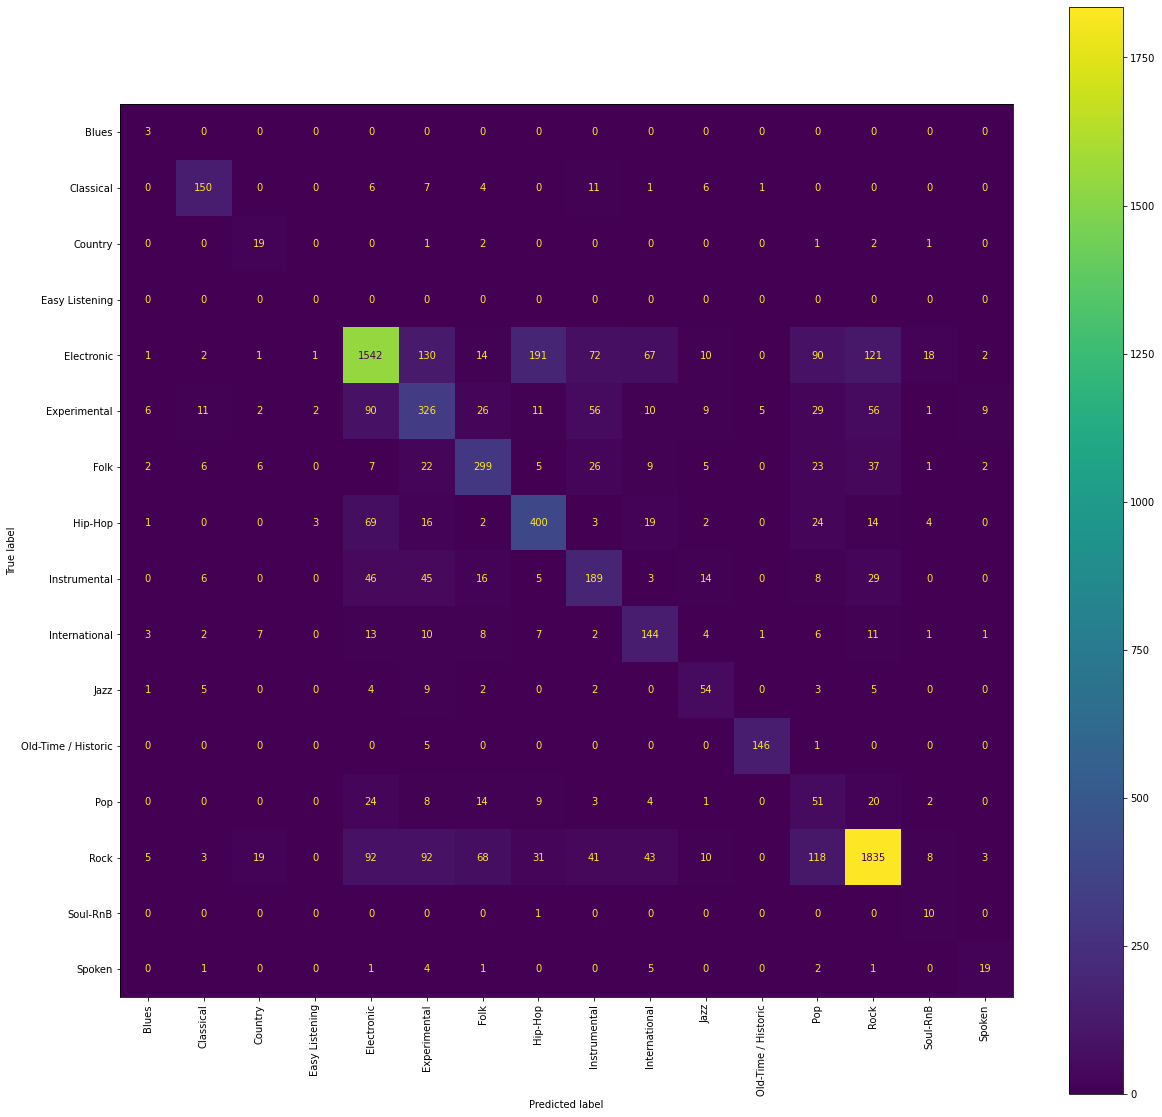

In [ ]:
conf_mat = ConfusionMatrixDisplay(confusion_matrix (y_pred_test_best_svc_pca, y_test_encoded),display_labels=converter.inverse_transform(best_knn_var_mutual.classes_))
fig, ax = plt.subplots(figsize=(20,20))
conf_mat.plot(ax=ax)
plt.xticks(rotation='vertical', fontsize = 10)
plt.show()

In [ ]:
pipe = Pipeline(steps=[("var_thresh", var_thresh), ("zscore", zscore), ("mutual", mutual), ("SVC", SVC)])
param_grid = {
    "SVC__C": [1,5,8],
    "SVC__gamma": [0.001,0.0005,0.00075]
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1, n_jobs = -1)
search.fit(X_train,y_train_encoded)


In [ ]:
results_svc_var_mutual = pd.read_csv("/content/drive/MyDrive/results_SVC_var_mutual.csv", index_col = [0])
best_param =results_svc_var_mutual.loc[results_svc_var_mutual["rank_test_score"] == 1, ["param_SVC__C", "param_SVC__gamma"]]
best_param

,param_SVC__C,param_SVC__gamma
6,8,0.001


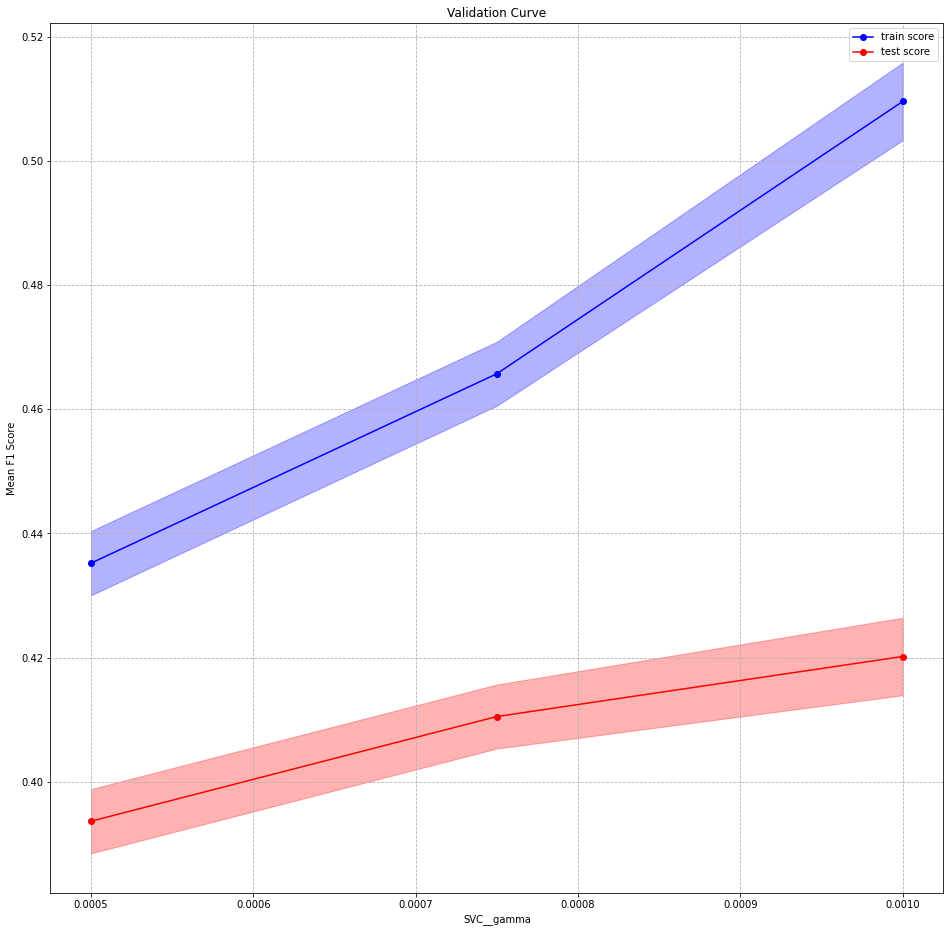

In [ ]:
plot_validation_curve_from_df(results_svc_var_mutual,"SVC__C", 8, "SVC__gamma")

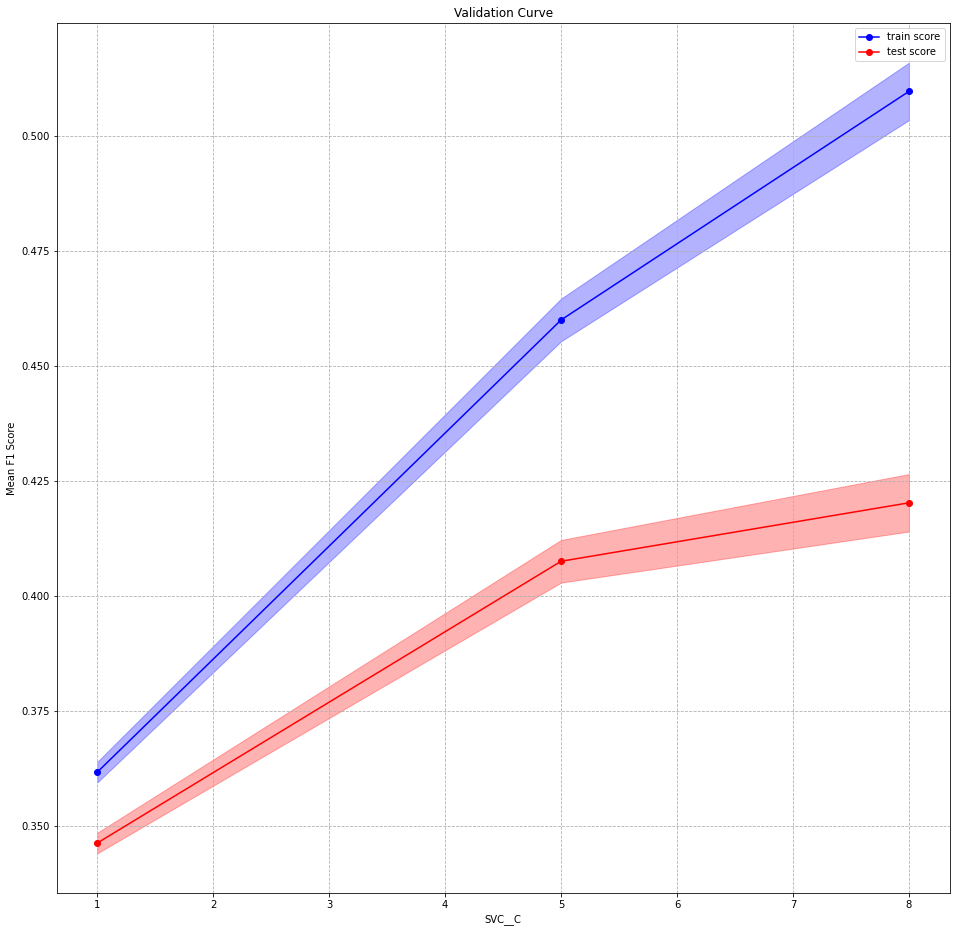

In [ ]:
plot_validation_curve_from_df(results_svc_var_mutual,"SVC__gamma", 0.001, "SVC__C")

In [ ]:
y_pred_test_best_svc_var_mutual = pd.read_csv("/content/drive/MyDrive/y_pred_test_SVC_var_mutual_df.csv", header = None)
y_pred_train_best_svc_var_mutual = pd.read_csv("/content/drive/MyDrive/y_pred_train_SVC_var_mutual_df.csv",  header = None)


print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_svc_var_mutual)))

                     precision    recall  f1-score   support

              Blues       1.00      0.05      0.09        22
          Classical       0.76      0.78      0.77       186
            Country       0.67      0.04      0.07        54
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.64      0.82      0.72      1894
       Experimental       0.53      0.40      0.46       675
               Folk       0.64      0.66      0.65       456
            Hip-Hop       0.71      0.60      0.65       660
       Instrumental       0.51      0.43      0.47       405
      International       0.61      0.37      0.46       305
               Jazz       0.54      0.29      0.38       115
Old-Time / Historic       0.97      0.95      0.96       153
                Pop       0.26      0.03      0.05       356
               Rock       0.73      0.87      0.79      2131
           Soul-RnB       0.00      0.00      0.00        46
             Spoken    

In [ ]:
f1_score_train["svc_var_mutual"] = f1_score(y_train_encoded,y_pred_train_best_svc_var_mutual, average='macro')
f1_score_test["svc_var_mutual"] = f1_score(y_test_encoded, y_pred_test_best_svc_var_mutual, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["svc_var_mutual"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["svc_var_mutual"]))

mean f1_score su dati addestramento: 0.499
mean f1_score su dati test:  0.440


In [ ]:
pipe = smotepipeline(steps=[("zscore", zscore), ("pca", pca),("smote",smote),("SVC", SVC)])
param_grid = {
   "smote__sampling_strategy": [dictio_resampling_1,dictio_resampling_2,dictio_resampling_3],
    "SVC__C": [1,5,8],
    "SVC__gamma": [0.001,0.0005,0.00075]
}

search = GridSearchCV(pipe, param_grid, cv = cv_stratified, scoring ='f1_macro', return_train_score=True, verbose = 1)
search.fit(X_train,y_train_encoded)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('zscore', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('smote', SMOTE()), ('SVC', SVC())]),
             param_grid={'SVC__C': [1, 5, 8],
                         'SVC__gamma': [0.001, 0.0005, 0.00075],
                         'smote__sampling_strategy': [{0: 1200, 1: 1200,
                                                       2: 1200, 3: 1200,
                                                       4: 4420, 5: 1576,
                                                       6: 1200, 7: 1541,
                                                       8: 1200, 9: 1200,
                                                       10: 1200, 11: 1200,
                                                       12: 1200, 13: 4972,
                                                       14: 1200, 15: 1200},
    

In [ ]:
best_scv_pca_smote = search.best_estimator_
search.best_params_

{'SVC__C': 5,
 'SVC__gamma': 0.001,
 'smote__sampling_strategy': {0: 1200,
  1: 1200,
  2: 1200,
  3: 1200,
  4: 4420,
  5: 1576,
  6: 1200,
  7: 1541,
  8: 1200,
  9: 1200,
  10: 1200,
  11: 1200,
  12: 1200,
  13: 4972,
  14: 1200,
  15: 1200}}

In [ ]:
results = pd.DataFrame(search.cv_results_)

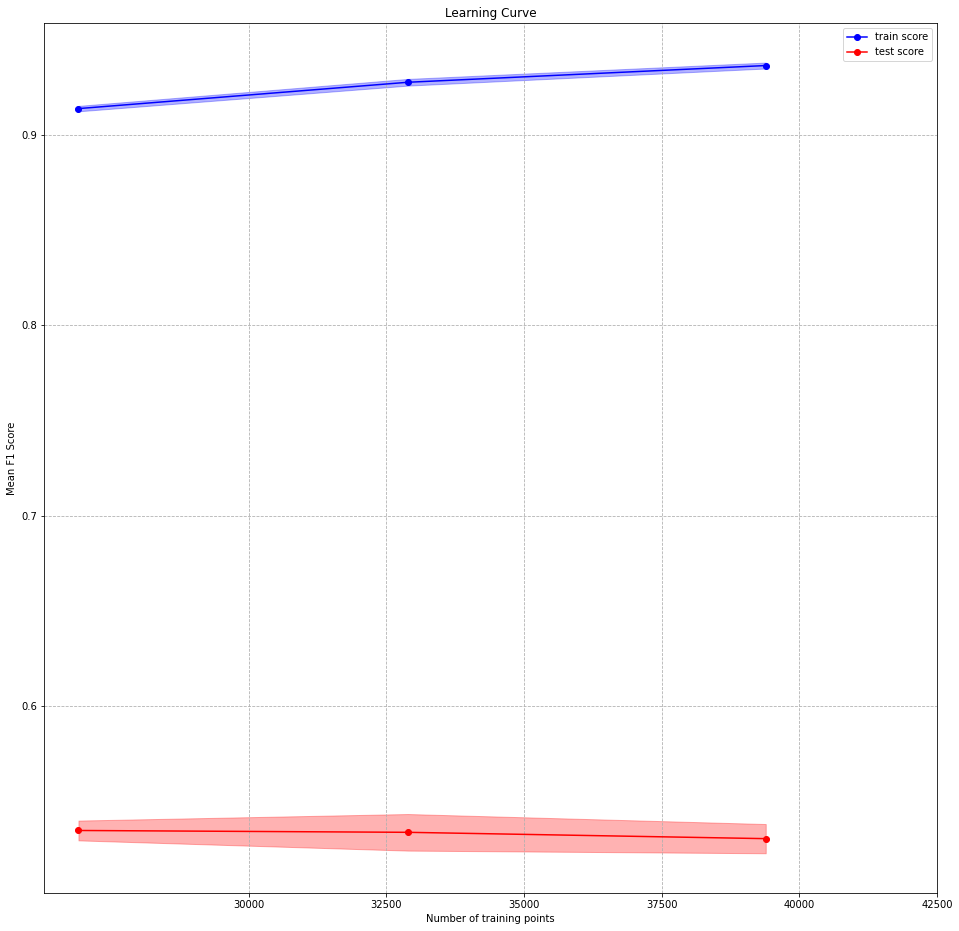

In [ ]:
plot_learning_curve(train_sizes,search,"SVC__C",5,"SVC__gamma", 0.001)

In [ ]:
y_pred_test_best_svc_pca_smote = best_scv_pca_smote.predict(X_test)
y_pred_train_best_svc_pca_smote = best_scv_pca_smote.predict(X_train)

print(classification_report(converter.inverse_transform(y_test_encoded),converter.inverse_transform(y_pred_test_best_svc_pca_smote)))

                     precision    recall  f1-score   support

              Blues       0.57      0.18      0.28        22
          Classical       0.79      0.79      0.79       186
            Country       0.60      0.52      0.55        54
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.68      0.81      0.74      1894
       Experimental       0.53      0.47      0.50       675
               Folk       0.68      0.64      0.66       456
            Hip-Hop       0.72      0.59      0.65       660
       Instrumental       0.49      0.45      0.47       405
      International       0.67      0.51      0.58       305
               Jazz       0.48      0.44      0.46       115
Old-Time / Historic       0.96      0.96      0.96       153
                Pop       0.33      0.19      0.24       356
               Rock       0.79      0.85      0.82      2131
           Soul-RnB       0.43      0.33      0.37        46
             Spoken    

In [ ]:
f1_score_train = {}
f1_score_test = {}

f1_score_train["svc_pca_smote"] = f1_score(y_train_encoded,y_pred_train_best_svc_pca_smote, average='macro')
f1_score_test["svc_pca_smote"] = f1_score(y_test_encoded, y_pred_test_best_svc_pca_smote, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["svc_pca_smote"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["svc_pca_smote"]))

mean f1_score su dati addestramento: 0.893
mean f1_score su dati test:  0.536


In [ ]:
f1_score_test

{'svc_pca_smote': 0.5362579709343829,
 'svc_var_mutual': 0.44016952348081834,
 'svc_pca': 0.5330978760786593,
 'knn_pca_smote': 0.3598650855232598,
 'knn_pca_var_mutual': 0.4858469154923938,
 'knn_pca': 0.4347358132841874}

<font size="5">**Rete Neurale MLP**</font>

Per le reti neurali *Multi Layer Perceptron* non si è effettuato un particolare studio sull'architettura o sugli iperparametri in gioco. Come funzioni di attivazione si sono scelte le relu, oramai le funzioni di attivazione largamente più usate e che ben mitigano il problema del *vanishing gradient* che avviene nelle reti profonde, cosi come l'ottimizzatore Adam, estensione molto popolare del gradient descent, con learning rate adattivo. Si sono fatti inoltre uso di tecniche di regolarizzazioni quali Dropout e L2

In [ ]:
X_pca_train_val_scaled, X_pca_val_scaled_val, y_train_val_encoded, y_val_encoded = train_test_split(X_pca_train_scaled,y_train_encoded,test_size =0.2, random_state=42, stratify=y_train_encoded)
y_train_categorical = to_categorical(y_train_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)

epochs = 50
batch_size = 128
opt = tf.keras.optimizers.Adam(learning_rate=0.001)



model_pca = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_pca_train_val_scaled.shape[1],),kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
       
    keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(16, activation="softmax"),
    
])

model_pca.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                   metrics=['accuracy', Precision(), Recall()])
model_pca.fit(X_pca_train_val_scaled, y_train_categorical, validation_data=(X_pca_val_scaled_val, y_val_categorical), epochs=epochs, 
                     batch_size=batch_size)
print(model_pca.summary())

Epoch 1/50
110/110 [==============================] - 2s 7ms/step - loss: 11.3602 - accuracy: 0.4921 - precision_3: 0.6963 - recall_3: 0.3490 - val_loss: 4.9085 - val_accuracy: 0.6066 - val_precision_3: 0.9280 - val_recall_3: 0.1437
Epoch 2/50
110/110 [==============================] - 1s 5ms/step - loss: 3.1330 - accuracy: 0.6061 - precision_3: 0.7396 - recall_3: 0.4807 - val_loss: 2.3819 - val_accuracy: 0.5771 - val_precision_3: 0.8944 - val_recall_3: 0.2251
Epoch 3/50
110/110 [==============================] - 1s 5ms/step - loss: 1.8885 - accuracy: 0.6305 - precision_3: 0.7549 - recall_3: 0.5121 - val_loss: 1.8347 - val_accuracy: 0.5746 - val_precision_3: 0.8171 - val_recall_3: 0.3523
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 1.6253 - accuracy: 0.6339 - precision_3: 0.7553 - recall_3: 0.5211 - val_loss: 1.6481 - val_accuracy: 0.6063 - val_precision_3: 0.7995 - val_recall_3: 0.4011
Epoch 5/50
110/110 [==============================] - 1s 5ms/step - los

In [ ]:
y_pred_train_MLP_pca = model_pca.predict(X_pca_train_scaled).argmax(1)
y_pred_test_MLP_pca = model_pca.predict(X_pca_test_scaled).argmax(1)
f1_score_train["MLP_pca"] = f1_score(y_train_encoded, y_pred_train_MLP_pca, average='macro')
f1_score_test["MLP_pca"] = f1_score(y_test_encoded, y_pred_test_MLP_pca, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["MLP_pca"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["MLP_pca"]))

mean f1_score su dati addestramento: 0.605
mean f1_score su dati test:  0.459


In [ ]:
X_var_mutual_train_val_scaled, X_var_mutual_val_scaled_val, y_train_val_encoded, y_val_encoded = train_test_split(X_train_var_mutual_scaled,y_train_encoded,test_size =0.2, random_state=42, stratify=y_train_encoded)
y_train_categorical = to_categorical(y_train_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)
y_val_categorical = to_categorical(y_val_encoded)

model_var_mutual = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_var_mutual_train_val_scaled.shape[1],),kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
       
    keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(16, activation="softmax"),
    
])

model_var_mutual.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                   metrics=['accuracy', Precision(), Recall()])
model_var_mutual.fit(X_var_mutual_train_val_scaled, y_train_categorical, validation_data=(X_var_mutual_val_scaled_val, y_val_categorical), epochs=epochs, 
                     batch_size=batch_size)
print(model_var_mutual.summary())

Epoch 1/50
110/110 [==============================] - 2s 10ms/step - loss: 11.2129 - accuracy: 0.5107 - precision_4: 0.6974 - recall_4: 0.3626 - val_loss: 5.2902 - val_accuracy: 0.5597 - val_precision_4: 0.9727 - val_recall_4: 0.0306
Epoch 2/50
110/110 [==============================] - 1s 5ms/step - loss: 3.2428 - accuracy: 0.6035 - precision_4: 0.7421 - recall_4: 0.4759 - val_loss: 2.5179 - val_accuracy: 0.5211 - val_precision_4: 0.9215 - val_recall_4: 0.1509
Epoch 3/50
110/110 [==============================] - 1s 12ms/step - loss: 1.9344 - accuracy: 0.6059 - precision_4: 0.7421 - recall_4: 0.4834 - val_loss: 1.8811 - val_accuracy: 0.5520 - val_precision_4: 0.8396 - val_recall_4: 0.3140
Epoch 4/50
110/110 [==============================] - 1s 6ms/step - loss: 1.6398 - accuracy: 0.6149 - precision_4: 0.7474 - recall_4: 0.4918 - val_loss: 1.6488 - val_accuracy: 0.5751 - val_precision_4: 0.8130 - val_recall_4: 0.3740
Epoch 5/50
110/110 [==============================] - 1s 6ms/step - l

In [ ]:
y_pred_train_MLP_var_mutual = model_var_mutual.predict(X_train_var_mutual_scaled).argmax(1)
y_pred_test_MLP_var_mutual = model_var_mutual.predict(X_test_var_mutual_scaled).argmax(1)
f1_score_train["MLP_var_mutual"] = f1_score(y_train_encoded, y_pred_train_MLP_var_mutual, average='macro')
f1_score_test["MLP_var_mutual"] = f1_score(y_test_encoded, y_pred_test_MLP_var_mutual, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["MLP_var_mutual"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["MLP_var_mutual"]))

mean f1_score su dati addestramento: 0.459
mean f1_score su dati test:  0.422


In [ ]:
dic_resampling_mode_2 = {0:1500, 1:1500, 2:1500,3:1500,4:4420,5:2750,6:1500,7:2750,8:1500,9:1500,10:1500,11:1500,12:1500,13:4972,14:1500,15:1500}
X_train_val_resample, y_train_val_resample = SMOTE(dic_resampling_mode_2).fit_resample(X_pca_train_scaled,y_train_encoded)
y_train_val_resample_categorical = to_categorical(y_train_val_resample)


model_pca_smote = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_var_mutual_train_val_scaled.shape[1],),kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
       
    keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(16, activation="softmax"),
    
])
model_pca_smote.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                   metrics=['accuracy', Precision(), Recall()])
model_pca_smote.fit(X_train_val_resample, y_train_val_resample_categorical, validation_data=(X_pca_val_scaled_val, y_val_categorical), epochs=epochs, 
                     batch_size=batch_size)
print(model_pca_smote.summary())

Epoch 1/50
257/257 [==============================] - 4s 5ms/step - loss: 2.9322 - accuracy: 0.6142 - precision_7: 0.7686 - recall_7: 0.4829 - val_loss: 2.1351 - val_accuracy: 0.5894 - val_precision_7: 0.9308 - val_recall_7: 0.1423
Epoch 2/50
257/257 [==============================] - 1s 4ms/step - loss: 1.6286 - accuracy: 0.6828 - precision_7: 0.8172 - recall_7: 0.5675 - val_loss: 1.6553 - val_accuracy: 0.6769 - val_precision_7: 0.8650 - val_recall_7: 0.4340
Epoch 3/50
257/257 [==============================] - 1s 4ms/step - loss: 1.5109 - accuracy: 0.7054 - precision_7: 0.8264 - recall_7: 0.5946 - val_loss: 1.5731 - val_accuracy: 0.6697 - val_precision_7: 0.8162 - val_recall_7: 0.5037
Epoch 4/50
257/257 [==============================] - 1s 4ms/step - loss: 1.4398 - accuracy: 0.7163 - precision_7: 0.8346 - recall_7: 0.6116 - val_loss: 1.4618 - val_accuracy: 0.6986 - val_precision_7: 0.8224 - val_recall_7: 0.5543
Epoch 5/50
257/257 [==============================] - 1s 4ms/step - loss

In [ ]:
y_pred_train_MLP_pca_smote = model_pca_smote.predict(X_train_val_resample).argmax(1)
y_pred_test_MLP_pca_smote = model_pca_smote.predict(X_pca_test_scaled).argmax(1)
f1_score_train["MLP_pca_smote"] = f1_score(y_train_val_resample, y_pred_train_MLP_pca_smote, average='macro')
f1_score_test["MLP_pca_smote"] = f1_score(y_test_encoded, y_pred_test_MLP_pca_smote, average='macro')

print("mean f1_score su dati addestramento: {:.3f}".format(f1_score_train["MLP_pca_smote"]))
print("mean f1_score su dati test:  {:.3f}".format(f1_score_test["MLP_pca_smote"]))

mean f1_score su dati addestramento: 0.836
mean f1_score su dati test:  0.494


In conclusione si riportano in maniera riassuntiva le performance dei vari modelli. Si può osservare come sia la SVC che l'MLP mostrino un comportamento simile, entrambi i modelli hanno beneficiato dell'oversampling e in entrambi i modelli la configurazione "var_mutual" è la configurazione con meno divario tra le performance in fase di addestramento e di testing. KNN mostra invece un comportamento contrario ed è in generale il modello peggiore

Tuttavia, come suddetto, le performance generiche dei modelli non sono brillanti, questo sicuramente è legato in parte all'ostica distribuzione del dataset nelle varie classi. Forse un'esplorazione più approfondita degli iperparametri dei modelli e un più massiccio di oversampling può portare a risultati migliori. Si sarebbe potuto tenere in considerazione anche un undersampling delle classi maggioritarie come anche suggerito nel paper stesso di SMOTE. Si sono provati anche metodi ensemble come Random Forest o XGBoost ma non si è riuscito a trovare un buon tuning dei parametri data anche la molteplicità degli stessi, pertanto si è preferito non riportarli.

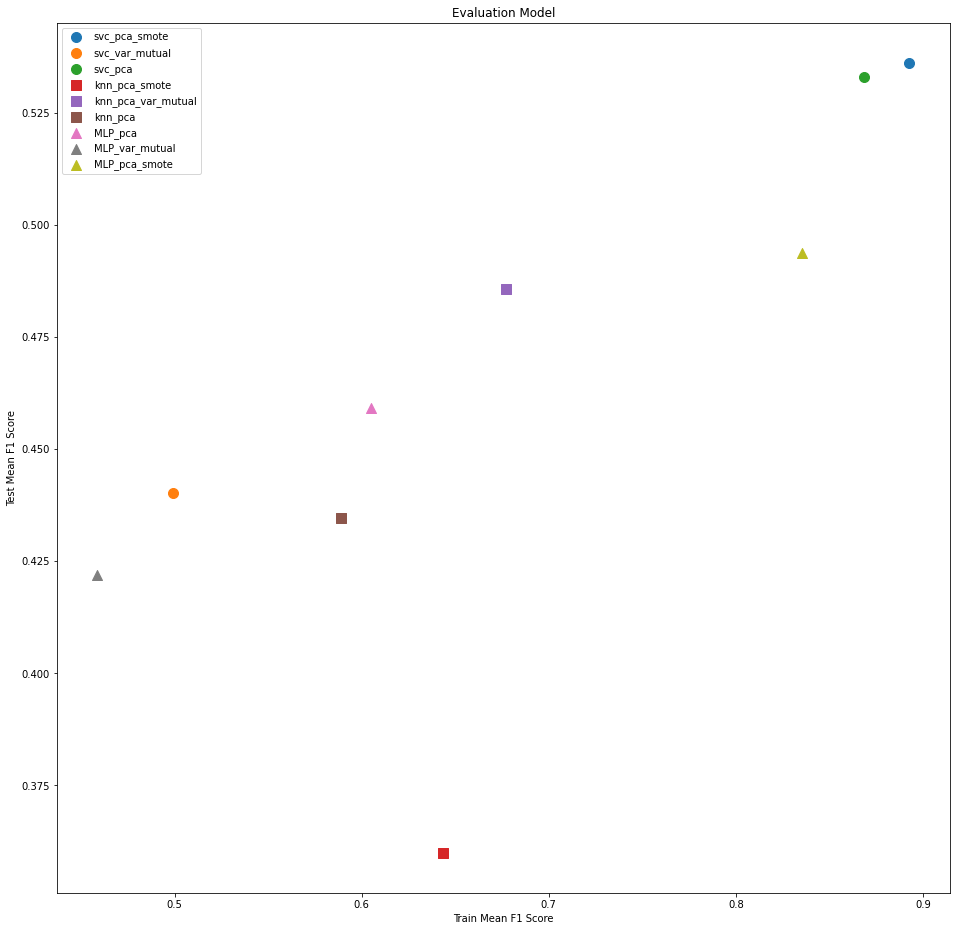

In [ ]:
evalution_model_scatter(f1_score_train,f1_score_test)

<font size="5">**CNN su Spettogrammi Mel**</font>

Di seguito si riporta un diverso approccio, non ben riuscito, di raggiungere performance migliori. Stando alla leaderboard della competizione o in generale alla letteratura relativa a tale campo, spesso, i risultati migliori, si raggiungono attraverso reti convoluzionali che lavorano su immagini di spettrogrammi ricavate dalle tracce audio. Pertanto l'intento è di ripercorrere la metodologia. La prima parte consiste nell'estrapolazione dei dati dalle tracce audio, che è stata eseguita su un altro notebook, ed è qui riportata. Nella seconda parte si importano i dati e si allena una rete convoluzionale sugli stessi.

<font size="3">**Prima Parte**</font>

Questa parte è legata alla creazione del dataset, ovvero a 24979 spettrogrammi Mel 128x128. La riduzione rispetto alle 25000 tracce audio fornite dal dataset è dovuta al rilevamento di 15 file corrotti e 6 tracce la cui durata ha determinato una matrice 128x7.

In [ ]:
!curl -O "https://os.unil.cloud.switch.ch/fma/fma_medium.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.1G  100 22.1G    0     0  23.4M      0  0:16:08  0:16:08 --:--:-- 24.1M


Una volta scaricato lo zip di 22 Gb si è provato ad utilizzare tecniche di decompressione parallela per accelerare il processo

In [ ]:
import zipfile 
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

path = "/content/"
zip_filename = "/content/fma_medium.zip"
zf = zipfile.ZipFile('/content/fma_medium.zip')


with zipfile.ZipFile(zip_filename, 'r') as handle:
        files = handle.namelist()
n_workers = 2       
chunksize = round(len(files) / n_workers)
with ProcessPoolExecutor() as exe:
  for i in range(0, len(files), chunksize):

            filenames = files[i:(i + chunksize)]
            with ThreadPoolExecutor() as exe:  
            
              for filename in filenames:
                 zf.extract(filename,path)

In [ ]:
!rm /content/fma_medium/README.txt /content/fma_medium/checksums

E' stato necessario l'uso del software ffmpeg per identificare i file corrotti

In [ ]:
!find /content/fma_medium/ -name "*.mp3" -exec ffmpeg -i '{}' -f null -v 16 - \;

Error while decoding stream #0:0: Invalid data found when processing input
[mp3 @ 0x555c845e8000] Failed to read frame size: Could not seek to 1026.
/content/fma_medium/098/098571.mp3: Invalid argument
[mp3 @ 0x5650c0bd8f00] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3 @ 0x5650c0bd8f00] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
    Last message repeated 1 times
[mp3 @ 0x55e678114000] Failed to read frame size: Could not seek to 1026.
/content/fma_medium/098/098558.mp3: Invalid argument
[mp3 @ 0x55f5cf466000] Failed to read frame size: Could not seek to 1026.
/content/fma_medium/098/098560.mp3: Invalid argument
Error while decoding stream #0:0: Invalid data found when processing input
Error while decoding stream #0:0: Invalid data found when processing input
[mp3 @ 0x5566fa9fa000] Failed to read frame size: Could not seek to 1026.
/content/fma_medium/098/098559.mp3: Invalid argument
Error w

Nella seguente cella si estrapolano gli spettrogrammi Mel, si è osservato una difformità nel sampling rate ed è stato pertanto uniformato in maniera tale da creare immagini delle stesse dimensioni. Inoltre è stato necessario un downsampling sull'asse temporale, il paramentro di default generava dimensioni delle immagini tale per cui si incorreva facilmente in problemi di memoria. A tal proprosito si è fissato il parametro *hop_length*, che determina l'overlap tra due adiacenti finestre su cui è applicata la trasformata. Il valore pari a 10340 è stato scelto per amore della simmetria, in maniera tale da ottenere immagini di dimensione 128x128

In [ ]:
folders = sorted(os.listdir("/content/fma_medium"))
list_corrupted = ['126981','133297','98571','98558','98560','98559','105247','5574','108925','99134','143992','65753','127336','80391','1486']
list_count = []
all_index_song = []
mel_spec_dataset = []
index_song_corrupted = []
for folder in folders:
  files = os.listdir("/content/fma_medium/" + folder)
  list_count.append(len(files))
  for single_file in files:
    index_song = single_file.split(".")[0].lstrip("0")

    if (index_song not in list_corrupted) == True:
      signal_song, sr = librosa.load("/content/fma_medium/" + folder + "/"+ single_file, sr=44100, mono=True, duration = 29.99)
      all_index_song.append(index_song)
      mel = librosa.feature.melspectrogram(signal_song, hop_length = 10340)
      mel_db = librosa.power_to_db(mel)
      mel_spec_dataset.append(mel_db)

sum_count = np.sum(list_count)
sum_count

Tutto il processo è stato effettuato su diverse porzioni di tracce per poi essere salvate su diversi file json

In [ ]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)



# Serialization

jsonString = json.dumps(mel_spec_dataset, cls = NumpyArrayEncoder)
jsonFile = open("data", "w")
jsonFile.write(jsonString)

all_index_song_df = pd.DataFrame({"index_song":all_index_song})
all_index_song_df.to_csv("all_index_song.csv")

files.download('data.json')
files.download('all_index_song.csv')

<font size="3">**Seconda Parte**</font>

In questa parte, una volta creato il dataset si importano i vari file e si unifica il tutto.

In [ ]:
import json

with  open('/content/drive/MyDrive/data.json') as f:

  data = json.load(f)

In [ ]:
for i in range(len(data_2)):
  data.append(data_2[i])
for i in range(len(data)):
  data[i] = np.array(data[i])

A titolo illustrativo si mostra uno spettrogramma Mel estrapolato

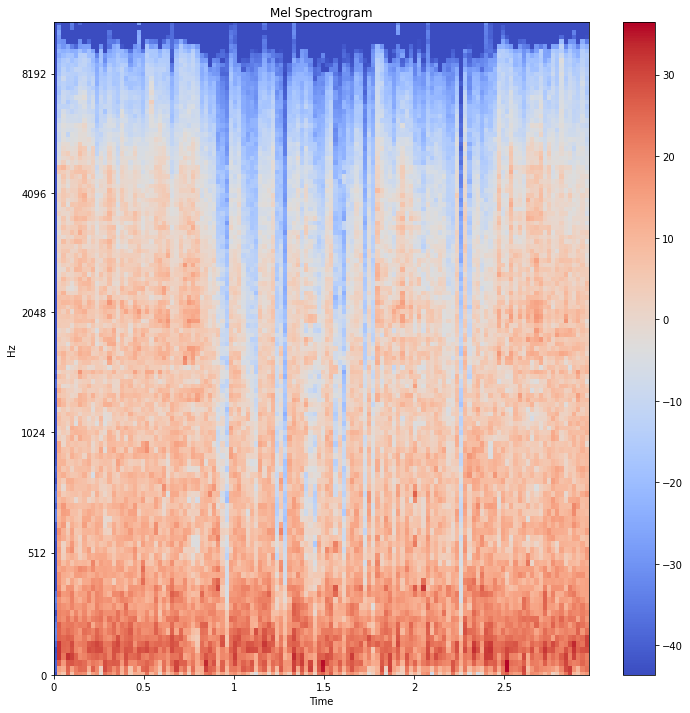

In [ ]:
librosa.display.specshow(data[0], y_axis='mel', x_axis='time');

plt.title('Mel Spectrogram');
plt.colorbar()

In [ ]:
index_img = pd.read_csv('/content/drive/MyDrive/all_index_song.csv', index_col = [0])
y_img= tracks.loc[index_img, ('track', 'genre_top')]
conv  = LabelEncoder()
y_img_categorical = to_categorical(conv.fit_transform(y_img))

Di seguito si mostra l'addestramento della rete convoluzionale eseguito mediante GPU. Problemi di memoria hanno ridotto la possibilità di aumentare i parametri della rete.

In [ ]:
savemodel = ModelCheckpoint(filepath = "/content/" + 'model.h5', verbose=1, save_best_only=True, save_weights_only=False)


data = np.array(data)

data, data_test, y_img_categorical_train, y_img_categorical_test = train_test_split(data, y_img_categorical, test_size =0.3, random_state=42, stratify=y_img_categorical)
input_shape=(128,128,1)
epochs = 40
batch_size = 32


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),input_shape=input_shape, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv2D(256,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv2D(512,(3,3),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv2D(512,(1,1),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(keras.layers.Dropout(0.3))


model.add(keras.layers.Dense(16,activation='softmax'))
model.summary()
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy', Precision(), Recall()])
history=model.fit(data,y_img_categorical_train,epochs=epochs,batch_size=batch_size, validation_data=(data_test,y_img_categorical_test), callbacks = [savemodel])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 128)      0

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/' + 'model.h5', custom_objects=None, compile=True)

In [ ]:
predict_CNN=model.predict(data_test).argmax(1)

In [ ]:
print(classification_report(conv.inverse_transform(y_img_categorical_test.argmax(1)),conv.inverse_transform(predict_CNN)))

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        22
          Classical       0.72      0.66      0.69       186
            Country       0.00      0.00      0.00        53
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.66      0.77      0.71      1893
       Experimental       0.42      0.46      0.44       675
               Folk       0.58      0.62      0.60       456
            Hip-Hop       0.63      0.72      0.67       658
       Instrumental       0.41      0.31      0.36       405
      International       0.55      0.36      0.44       306
               Jazz       0.00      0.00      0.00       115
Old-Time / Historic       0.98      0.92      0.95       153
                Pop       0.00      0.00      0.00       356
               Rock       0.71      0.83      0.76      2129
           Soul-RnB       0.00      0.00      0.00        46
             Spoken    

Come si può osservare i risultati non sono soddisfacenti alcune classi sono completamente ignorate, ma chiaramente l'intero processo ha ampi margini di manovra. Come ad esempio l'applicazione di tecniche di oversampling oppure tecniche di data augmentation tramite median filter per scomporre gli armonici dalle percussioni.